In [1]:
from datetime import datetime
import math
from typing import Any, Dict, Iterable, Optional, Sequence, Union

import torch
from torch.optim.optimizer import Optimizer
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets import load_dataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

/home/hkuo/miniforge3/envs/cs-439/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Custom Adam optimizer with low-rank compression

In [2]:
def stable_randn(
        shape: Union[int, Sequence[int]],
        seed: int,
        device: Optional[Union[str, torch.device]] = None,
        dtype: Optional[torch.dtype] = torch.float32,
) -> torch.Tensor:
    if device is None:
        device = torch.device("cpu")
    generator = torch.Generator(device=device).manual_seed(seed)
    rn = torch.randn(shape, generator=generator, device=generator.device, dtype=dtype)
    return rn


def next_seed(seed: int, adv: int = 0xF) -> int:
    """
    This is a naive helper function to generate a new seed from the given seed.
    """
    generator = torch.Generator().manual_seed(seed)
    return torch.randint(
        0, torch.iinfo(torch.int64).max, (adv,), generator=generator, device=generator.device
    ).tolist()[-1]


def split_seed(seed: int) -> tuple[int, int]:
    generator = torch.Generator().manual_seed(seed)
    return tuple(
        torch.randint(0, torch.iinfo(torch.int64).max, (2,), generator=generator, device=generator.device).tolist()
    )

In [3]:
class FloraAdam(Optimizer):
    def __init__(
            self,
            params: Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]],
            lr:float = None,
            betas: tuple[float, float] = (0.9, 0.999),
            eps: float = 1e-8,
            rank: int = None,
            kappa: int = 1000,
            seed: int = 0,
    ) -> None:

        defaults = {
            "lr": lr,
            "betas": betas,
            "eps": eps,
            "rank": rank,
            "kappa": kappa,

        }
        super().__init__(params, defaults)

        params_idx = seed
        for group in self.param_groups:
            for p in group["params"]:
                params_idx += 1
                if p.requires_grad:
                    self.state[p]["seed"] = params_idx

    @staticmethod
    def _should_compress(param_group: Dict, param_shape: tuple[int, ...]) -> tuple[bool, bool, bool]:
        factored = len(param_shape) == 2
        should_compress= (
                param_group["rank"] is not None
                and param_group["rank"] > 0
                and factored
                and min(param_shape) >= param_group["rank"]
                and max(param_shape) / min(param_shape) <= 4  # rule out embeddings
        )
        return should_compress

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr, (beta1, beta2), eps = group['lr'], group['betas'], group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                grad_shape = grad.shape
                should_compress = self._should_compress(group, grad_shape)

                state = self.state[p]

                # State initialization
                if (state and'step' not in state) or (not state):
                    state['step'] = 0

                    if should_compress:
                        if grad_shape[0] < grad_shape[-1]:
                            cshape = (group["rank"], grad_shape[-1])
                        else:
                            cshape = (grad_shape[0], group["rank"])

                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros(cshape).to(grad)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p)

                    else:
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']

                if should_compress:
                    def _down_proj(seed, rank, tensor):
                        lseed, rseed = split_seed(seed)
                        if tensor.shape[0] < tensor.shape[-1]:
                            left_projection = stable_randn(
                                (rank, tensor.shape[0]),
                                seed=lseed,
                                device=tensor.device,
                                dtype=tensor.dtype,
                            ) / math.sqrt(rank)

                            return left_projection @ tensor
                        else:
                            right_projection = stable_randn(
                                (tensor.shape[-1], rank),
                                seed=rseed,
                                device=tensor.device,
                                dtype=tensor.dtype,
                            ) / math.sqrt(rank)
                        return tensor @ right_projection

                    def _up_proj(seed, rank, shape, ctensor):
                        lseed, rseed = split_seed(seed)
                        if shape[0] < shape[-1]:
                            left_projection = stable_randn(
                                (rank, shape[0]),
                                seed=lseed,
                                device=ctensor.device,
                                dtype=ctensor.dtype,
                            ) / math.sqrt(rank)
                            return left_projection.t() @ ctensor
                        else:
                            right_projection = stable_randn(
                                (shape[-1], rank),
                                seed=rseed,
                                device=ctensor.device,
                                dtype=ctensor.dtype,
                            ) / math.sqrt(rank)
                            return ctensor @ right_projection.t()

                    _current_seed = state["seed"]

                    cgrad = _down_proj(seed=_current_seed, rank=group["rank"], tensor=grad)
                    # Update biased first moment estimate
                    exp_avg.mul_(beta1).add_(cgrad, alpha=1 - beta1)
                    # Update biased second raw moment estimate
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                    # Compute bias-corrected moments
                    bias_correction1 = 1 - beta1 ** t
                    bias_correction2 = 1 - beta2 ** t
                    corrected_avg = exp_avg / bias_correction1
                    corrected_avg_sq = exp_avg_sq / bias_correction2

                    # Parameter update
                    denom = corrected_avg_sq.sqrt().add_(eps)

                    p.addcdiv_(_up_proj(seed=_current_seed, rank=group["rank"], shape=grad_shape, ctensor=corrected_avg),
                               denom,
                               value=-lr)

                    # Time for a new seed
                    if state["step"] % group["kappa"] == 0:
                        _next_seed = next_seed(state["seed"])

                        state["exp_avg"].copy_(
                            _down_proj(
                                seed=_next_seed,
                                rank=group["rank"],
                                tensor=_up_proj(
                                    seed=_current_seed,
                                    rank=group["rank"],
                                    shape=grad_shape,
                                    ctensor=state["exp_avg"]
                                ),
                            )
                        )

                        state["seed"] = _next_seed
                        _current_seed = _next_seed

                else:
                    # Update biased first moment estimate
                    exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                    # Update biased second raw moment estimate
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                    # Compute bias-corrected moments
                    bias_correction1 = 1 - beta1 ** t
                    bias_correction2 = 1 - beta2 ** t
                    corrected_avg = exp_avg / bias_correction1
                    corrected_avg_sq = exp_avg_sq / bias_correction2

                    # Parameter update
                    denom = corrected_avg_sq.sqrt().add_(eps)
                    p.addcdiv_(corrected_avg, denom, value=-lr)

        return loss


# Custom Adam optimizer

In [4]:
class CustomAdam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid lr: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid eps: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta1: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta2: {betas[1]}")

        defaults = dict(lr=lr, betas=betas, eps=eps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr, (beta1, beta2), eps = group['lr'], group['betas'], group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad

                # State initialization
                state = self.state[p]
                if not state:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                state['step'] += 1
                t = state['step']

                # Update biased first moment estimate
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                # Update biased second raw moment estimate
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Compute bias-corrected moments
                bias_correction1 = 1 - beta1 ** t
                bias_correction2 = 1 - beta2 ** t
                corrected_avg = exp_avg / bias_correction1
                corrected_avg_sq = exp_avg_sq / bias_correction2

                # Parameter update
                denom = corrected_avg_sq.sqrt().add_(eps)
                p.addcdiv_(corrected_avg, denom, value=-lr)

        return loss

# Training

In [5]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)   # First linear layer
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second linear layer

    def forward(self, x):
        x = F.relu(self.fc1(x))        # Activation after first layer
        x = self.fc2(x)                # Second linear layer
        return x     # Softmax for class probabilities


In [6]:
input_size = 28 * 28
hidden_size = 256
num_classes = 10
batch_size = 256
lr = 1e-5
seed = 0
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model_flora = TwoLayerNet(input_size, hidden_size, num_classes).to(device)
model_adam = TwoLayerNet(input_size, hidden_size, num_classes).to(device)

# Training step
loss_fn_flora = nn.CrossEntropyLoss().to(device)
loss_fn_adam = nn.CrossEntropyLoss().to(device)

# optimizer = FloraAdamD(model.parameters(), lr=5e-2, betas=(0.9, 0.999), eps=1e-8, rank = 5, kappa = 100, seed = 0)
optimizer_flora = FloraAdam(
    model_flora.parameters(),
    lr=lr,
    betas=(0.9, 0.999),
    eps=1e-8,
    rank=5,
    kappa=100,
    seed=seed,
)
optimizer_adam = CustomAdam(
    model_adam.parameters(),
    lr=lr,
    betas=(0.9, 0.999),
    eps=1e-8,
)

# Store loss for plotting
loss_values_flora = []
loss_values_adam = []


Convert the dataset to a format suitable for PyTorch

In [7]:
def transform_data(examples):
    # Flatten the images and convert to float32
    images = [transforms.ToTensor()(image).flatten() for image in examples['image']]
    labels = examples['label']
    return {'inputs': images, 'labels': labels}

full_dataset = load_dataset('ylecun/mnist')
full_dataset = full_dataset.map(
    transform_data,
    remove_columns=['image', 'label'],
    num_proc=16,
    batched=True,
)
full_dataset.set_format(type='torch', columns=['inputs', 'labels'])

In [8]:
train_valid = full_dataset['train'].train_test_split(test_size=0.1)
train_dataset = train_valid['train']
validation_dataset = train_valid['test']

num_workers = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(full_dataset['test'], batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [ ]:
for batch in validation_dataloader:

    inputs = batch['inputs'].to(device)
    labels = batch['labels'].to(device)

    print(inputs.get_device())
    print(inputs.shape)
    break

In [9]:
def train_one_epoch(model, optimizer, loss_fn, train_dataloader, epoch_index, device=None):
    running_loss = 0.
    last_loss = 0.

    for i, batch in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        # if i % 1000 == 0:
        #     last_loss = running_loss / 1000 # loss per batch
        #     print('  batch {} loss: {}'.format(i + 1, last_loss))
        #     running_loss = 0.

    return last_loss

In [10]:
def train_model(model, epochs, train_dataloader, validation_dataloader, loss_fn, optimizer, device=None):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    best_vloss = 1_000_000.
    for epoch in tqdm(range(epochs)):
        # print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model, optimizer, loss_fn, train_dataloader, epoch, device=device)

        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            # Iterate over the validation dataset
            for i, batch in enumerate(validation_dataloader):
                # Every data instance is an input + label pair
                vinputs = batch['inputs'].to(device)
                vlabels = batch['labels'].to(device)

                # Make predictions for this batch
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

        epoch += 1

In [11]:
def evaluate_model(model, test_loader, device=None):
    all_labels = None
    all_preds = None

    for b in tqdm(test_loader):
        inputs = b['inputs'].to(device)
        labels = b['labels'].to(device)

        with torch.no_grad():
            outputs = model(inputs).argmax(dim=1)

        if all_labels is None:
            all_labels = labels.cpu()
            all_preds = outputs.cpu()
        else:
            all_labels = torch.concat([all_labels, labels.cpu()])
            all_preds = torch.concat([all_preds, outputs.cpu()])

    assert len(all_labels) == len(all_preds)

    acc = accuracy_score(all_labels, all_preds)

    print('Accuracy: ', acc * 100, '%')

    return all_preds, all_labels, acc

In [12]:
train_model(model_flora, epochs, train_dataloader, validation_dataloader, loss_fn_flora, optimizer_flora, device=device)
all_preds_flora, all_labels_flora, acc_flora = evaluate_model(model_flora, test_dataloader, device=device)

  0%|          | 1/500 [00:01<10:41,  1.29s/it]

LOSS train 0.0 valid 8.213451385498047


  0%|          | 2/500 [00:02<09:40,  1.17s/it]

LOSS train 0.0 valid 6.627391815185547


  1%|          | 3/500 [00:03<09:19,  1.13s/it]

LOSS train 0.0 valid 5.4138946533203125


  1%|          | 4/500 [00:04<09:14,  1.12s/it]

LOSS train 0.0 valid 4.492927074432373


  1%|          | 5/500 [00:05<09:09,  1.11s/it]

LOSS train 0.0 valid 3.818413257598877


  1%|          | 6/500 [00:06<09:03,  1.10s/it]

LOSS train 0.0 valid 3.3157613277435303


  1%|▏         | 7/500 [00:07<09:01,  1.10s/it]

LOSS train 0.0 valid 2.9164836406707764


  2%|▏         | 8/500 [00:08<09:07,  1.11s/it]

LOSS train 0.0 valid 2.5788474082946777


  2%|▏         | 9/500 [00:10<09:03,  1.11s/it]

LOSS train 0.0 valid 2.257500410079956


  2%|▏         | 10/500 [00:11<09:05,  1.11s/it]

LOSS train 0.0 valid 2.0162453651428223


  2%|▏         | 11/500 [00:12<09:04,  1.11s/it]

LOSS train 0.0 valid 1.7995399236679077


  2%|▏         | 12/500 [00:13<08:59,  1.11s/it]

LOSS train 0.0 valid 1.6182845830917358


  3%|▎         | 13/500 [00:14<08:59,  1.11s/it]

LOSS train 0.0 valid 1.4525980949401855


  3%|▎         | 14/500 [00:15<08:59,  1.11s/it]

LOSS train 0.0 valid 1.3096141815185547


  3%|▎         | 15/500 [00:16<08:56,  1.11s/it]

LOSS train 0.0 valid 1.1759166717529297


  3%|▎         | 16/500 [00:17<08:52,  1.10s/it]

LOSS train 0.0 valid 1.0708208084106445


  3%|▎         | 17/500 [00:18<08:51,  1.10s/it]

LOSS train 0.0 valid 0.9918932914733887


  4%|▎         | 18/500 [00:19<08:49,  1.10s/it]

LOSS train 0.0 valid 0.9114409685134888


  4%|▍         | 19/500 [00:21<08:51,  1.10s/it]

LOSS train 0.0 valid 0.8430205583572388


  4%|▍         | 20/500 [00:22<08:48,  1.10s/it]

LOSS train 0.0 valid 0.7894065380096436


  4%|▍         | 21/500 [00:23<08:51,  1.11s/it]

LOSS train 0.0 valid 0.741518497467041


  4%|▍         | 22/500 [00:24<08:48,  1.11s/it]

LOSS train 0.0 valid 0.7040113210678101


  5%|▍         | 23/500 [00:25<08:45,  1.10s/it]

LOSS train 0.0 valid 0.6641139984130859


  5%|▍         | 24/500 [00:26<08:47,  1.11s/it]

LOSS train 0.0 valid 0.629399299621582


  5%|▌         | 25/500 [00:27<08:42,  1.10s/it]

LOSS train 0.0 valid 0.6042876243591309


  5%|▌         | 26/500 [00:28<08:41,  1.10s/it]

LOSS train 0.0 valid 0.5763224363327026


  5%|▌         | 27/500 [00:29<08:40,  1.10s/it]

LOSS train 0.0 valid 0.5525463819503784


  6%|▌         | 28/500 [00:31<08:39,  1.10s/it]

LOSS train 0.0 valid 0.5304886698722839


  6%|▌         | 29/500 [00:32<08:40,  1.11s/it]

LOSS train 0.0 valid 0.5120905637741089


  6%|▌         | 30/500 [00:33<08:37,  1.10s/it]

LOSS train 0.0 valid 0.49552690982818604


  6%|▌         | 31/500 [00:34<08:37,  1.10s/it]

LOSS train 0.0 valid 0.48020613193511963


  6%|▋         | 32/500 [00:35<08:36,  1.10s/it]

LOSS train 0.0 valid 0.4657841920852661


  7%|▋         | 33/500 [00:36<08:39,  1.11s/it]

LOSS train 0.0 valid 0.45094209909439087


  7%|▋         | 34/500 [00:37<08:39,  1.11s/it]

LOSS train 0.0 valid 0.43934834003448486


  7%|▋         | 35/500 [00:38<08:39,  1.12s/it]

LOSS train 0.0 valid 0.42862725257873535


  7%|▋         | 36/500 [00:39<08:36,  1.11s/it]

LOSS train 0.0 valid 0.4177365005016327


  7%|▋         | 37/500 [00:41<08:34,  1.11s/it]

LOSS train 0.0 valid 0.40994179248809814


  8%|▊         | 38/500 [00:42<08:28,  1.10s/it]

LOSS train 0.0 valid 0.40023189783096313


  8%|▊         | 39/500 [00:43<08:27,  1.10s/it]

LOSS train 0.0 valid 0.39160284399986267


  8%|▊         | 40/500 [00:44<08:26,  1.10s/it]

LOSS train 0.0 valid 0.38320833444595337


  8%|▊         | 41/500 [00:45<08:22,  1.09s/it]

LOSS train 0.0 valid 0.3756323754787445


  8%|▊         | 42/500 [00:46<08:17,  1.09s/it]

LOSS train 0.0 valid 0.36865052580833435


  9%|▊         | 43/500 [00:47<08:20,  1.10s/it]

LOSS train 0.0 valid 0.3620154559612274


  9%|▉         | 44/500 [00:48<08:22,  1.10s/it]

LOSS train 0.0 valid 0.3548430800437927


  9%|▉         | 45/500 [00:49<08:24,  1.11s/it]

LOSS train 0.0 valid 0.3480440378189087


  9%|▉         | 46/500 [00:50<08:26,  1.12s/it]

LOSS train 0.0 valid 0.342599481344223


  9%|▉         | 47/500 [00:52<08:31,  1.13s/it]

LOSS train 0.0 valid 0.3375414311885834


 10%|▉         | 48/500 [00:53<08:27,  1.12s/it]

LOSS train 0.0 valid 0.3320796489715576


 10%|▉         | 49/500 [00:54<08:21,  1.11s/it]

LOSS train 0.0 valid 0.3279394507408142


 10%|█         | 50/500 [00:55<08:15,  1.10s/it]

LOSS train 0.0 valid 0.3243356943130493


 10%|█         | 51/500 [00:56<08:12,  1.10s/it]

LOSS train 0.0 valid 0.31988200545310974


 10%|█         | 52/500 [00:57<08:11,  1.10s/it]

LOSS train 0.0 valid 0.31602877378463745


 11%|█         | 53/500 [00:58<08:15,  1.11s/it]

LOSS train 0.0 valid 0.31272226572036743


 11%|█         | 54/500 [00:59<08:20,  1.12s/it]

LOSS train 0.0 valid 0.30884313583374023


 11%|█         | 55/500 [01:00<08:14,  1.11s/it]

LOSS train 0.0 valid 0.30479419231414795


 11%|█         | 56/500 [01:02<08:14,  1.11s/it]

LOSS train 0.0 valid 0.3020506501197815


 11%|█▏        | 57/500 [01:03<08:11,  1.11s/it]

LOSS train 0.0 valid 0.29863566160202026


 12%|█▏        | 58/500 [01:04<08:08,  1.10s/it]

LOSS train 0.0 valid 0.29525837302207947


 12%|█▏        | 59/500 [01:05<08:05,  1.10s/it]

LOSS train 0.0 valid 0.2920847237110138


 12%|█▏        | 60/500 [01:06<08:09,  1.11s/it]

LOSS train 0.0 valid 0.28941264748573303


 12%|█▏        | 61/500 [01:07<08:08,  1.11s/it]

LOSS train 0.0 valid 0.28627413511276245


 12%|█▏        | 62/500 [01:08<08:07,  1.11s/it]

LOSS train 0.0 valid 0.2833743691444397


 13%|█▎        | 63/500 [01:09<08:04,  1.11s/it]

LOSS train 0.0 valid 0.28067493438720703


 13%|█▎        | 64/500 [01:10<08:00,  1.10s/it]

LOSS train 0.0 valid 0.27784067392349243


 13%|█▎        | 65/500 [01:11<07:56,  1.10s/it]

LOSS train 0.0 valid 0.27549153566360474


 13%|█▎        | 66/500 [01:13<07:55,  1.10s/it]

LOSS train 0.0 valid 0.2733666002750397


 13%|█▎        | 67/500 [01:14<07:53,  1.09s/it]

LOSS train 0.0 valid 0.2710072696208954


 14%|█▎        | 68/500 [01:15<07:54,  1.10s/it]

LOSS train 0.0 valid 0.26899558305740356


 14%|█▍        | 69/500 [01:16<07:50,  1.09s/it]

LOSS train 0.0 valid 0.2662815749645233


 14%|█▍        | 70/500 [01:17<07:50,  1.09s/it]

LOSS train 0.0 valid 0.2646714746952057


 14%|█▍        | 71/500 [01:18<07:49,  1.09s/it]

LOSS train 0.0 valid 0.26269060373306274


 14%|█▍        | 72/500 [01:19<07:50,  1.10s/it]

LOSS train 0.0 valid 0.2605936527252197


 15%|█▍        | 73/500 [01:20<07:51,  1.10s/it]

LOSS train 0.0 valid 0.25912022590637207


 15%|█▍        | 74/500 [01:21<07:48,  1.10s/it]

LOSS train 0.0 valid 0.25749313831329346


 15%|█▌        | 75/500 [01:22<07:50,  1.11s/it]

LOSS train 0.0 valid 0.2557167708873749


 15%|█▌        | 76/500 [01:24<07:47,  1.10s/it]

LOSS train 0.0 valid 0.25349879264831543


 15%|█▌        | 77/500 [01:25<07:43,  1.10s/it]

LOSS train 0.0 valid 0.251740038394928


 16%|█▌        | 78/500 [01:26<07:40,  1.09s/it]

LOSS train 0.0 valid 0.2500190734863281


 16%|█▌        | 79/500 [01:27<07:37,  1.09s/it]

LOSS train 0.0 valid 0.24803879857063293


 16%|█▌        | 80/500 [01:28<07:37,  1.09s/it]

LOSS train 0.0 valid 0.24659985303878784


 16%|█▌        | 81/500 [01:29<07:37,  1.09s/it]

LOSS train 0.0 valid 0.24507758021354675


 16%|█▋        | 82/500 [01:30<07:36,  1.09s/it]

LOSS train 0.0 valid 0.24354305863380432


 17%|█▋        | 83/500 [01:31<07:36,  1.10s/it]

LOSS train 0.0 valid 0.24225470423698425


 17%|█▋        | 84/500 [01:32<07:38,  1.10s/it]

LOSS train 0.0 valid 0.2407190501689911


 17%|█▋        | 85/500 [01:33<07:33,  1.09s/it]

LOSS train 0.0 valid 0.239241823554039


 17%|█▋        | 86/500 [01:35<07:34,  1.10s/it]

LOSS train 0.0 valid 0.2373584508895874


 17%|█▋        | 87/500 [01:36<07:35,  1.10s/it]

LOSS train 0.0 valid 0.23596173524856567


 18%|█▊        | 88/500 [01:37<07:31,  1.10s/it]

LOSS train 0.0 valid 0.23490643501281738


 18%|█▊        | 89/500 [01:38<07:33,  1.10s/it]

LOSS train 0.0 valid 0.23373620212078094


 18%|█▊        | 90/500 [01:39<07:36,  1.11s/it]

LOSS train 0.0 valid 0.23232071101665497


 18%|█▊        | 91/500 [01:40<07:32,  1.11s/it]

LOSS train 0.0 valid 0.2308797687292099


 18%|█▊        | 92/500 [01:41<07:29,  1.10s/it]

LOSS train 0.0 valid 0.229132741689682


 19%|█▊        | 93/500 [01:42<07:30,  1.11s/it]

LOSS train 0.0 valid 0.22892248630523682


 19%|█▉        | 94/500 [01:43<07:29,  1.11s/it]

LOSS train 0.0 valid 0.2275080680847168


 19%|█▉        | 95/500 [01:44<07:30,  1.11s/it]

LOSS train 0.0 valid 0.22643178701400757


 19%|█▉        | 96/500 [01:46<07:28,  1.11s/it]

LOSS train 0.0 valid 0.2255120575428009


 19%|█▉        | 97/500 [01:47<07:24,  1.10s/it]

LOSS train 0.0 valid 0.22405296564102173


 20%|█▉        | 98/500 [01:48<07:24,  1.11s/it]

LOSS train 0.0 valid 0.22299055755138397


 20%|█▉        | 99/500 [01:49<07:23,  1.10s/it]

LOSS train 0.0 valid 0.22159910202026367


 20%|██        | 100/500 [01:50<07:25,  1.11s/it]

LOSS train 0.0 valid 0.22054046392440796


 20%|██        | 101/500 [01:51<07:22,  1.11s/it]

LOSS train 0.0 valid 0.21947234869003296


 20%|██        | 102/500 [01:52<07:24,  1.12s/it]

LOSS train 0.0 valid 0.21845291554927826


 21%|██        | 103/500 [01:53<07:20,  1.11s/it]

LOSS train 0.0 valid 0.21763497591018677


 21%|██        | 104/500 [01:54<07:20,  1.11s/it]

LOSS train 0.0 valid 0.21645885705947876


 21%|██        | 105/500 [01:56<07:18,  1.11s/it]

LOSS train 0.0 valid 0.215163916349411


 21%|██        | 106/500 [01:57<07:15,  1.11s/it]

LOSS train 0.0 valid 0.21450063586235046


 21%|██▏       | 107/500 [01:58<07:11,  1.10s/it]

LOSS train 0.0 valid 0.21303412318229675


 22%|██▏       | 108/500 [01:59<07:10,  1.10s/it]

LOSS train 0.0 valid 0.21213428676128387


 22%|██▏       | 109/500 [02:00<07:08,  1.10s/it]

LOSS train 0.0 valid 0.2111981213092804


 22%|██▏       | 110/500 [02:01<07:09,  1.10s/it]

LOSS train 0.0 valid 0.20990309119224548


 22%|██▏       | 111/500 [02:02<07:08,  1.10s/it]

LOSS train 0.0 valid 0.209136962890625


 22%|██▏       | 112/500 [02:03<07:07,  1.10s/it]

LOSS train 0.0 valid 0.20829156041145325


 23%|██▎       | 113/500 [02:04<07:07,  1.10s/it]

LOSS train 0.0 valid 0.20752224326133728


 23%|██▎       | 114/500 [02:05<07:06,  1.10s/it]

LOSS train 0.0 valid 0.20651982724666595


 23%|██▎       | 115/500 [02:07<07:03,  1.10s/it]

LOSS train 0.0 valid 0.20615124702453613


 23%|██▎       | 116/500 [02:08<07:01,  1.10s/it]

LOSS train 0.0 valid 0.2048942893743515


 23%|██▎       | 117/500 [02:09<07:01,  1.10s/it]

LOSS train 0.0 valid 0.20374642312526703


 24%|██▎       | 118/500 [02:10<06:58,  1.10s/it]

LOSS train 0.0 valid 0.20302966237068176


 24%|██▍       | 119/500 [02:11<06:55,  1.09s/it]

LOSS train 0.0 valid 0.20232467353343964


 24%|██▍       | 120/500 [02:12<06:53,  1.09s/it]

LOSS train 0.0 valid 0.20160430669784546


 24%|██▍       | 121/500 [02:13<06:57,  1.10s/it]

LOSS train 0.0 valid 0.20066148042678833


 24%|██▍       | 122/500 [02:14<06:55,  1.10s/it]

LOSS train 0.0 valid 0.200016051530838


 25%|██▍       | 123/500 [02:15<06:55,  1.10s/it]

LOSS train 0.0 valid 0.19912266731262207


 25%|██▍       | 124/500 [02:16<06:52,  1.10s/it]

LOSS train 0.0 valid 0.1984807848930359


 25%|██▌       | 125/500 [02:18<06:49,  1.09s/it]

LOSS train 0.0 valid 0.19783304631710052


 25%|██▌       | 126/500 [02:19<06:50,  1.10s/it]

LOSS train 0.0 valid 0.19673208892345428


 25%|██▌       | 127/500 [02:20<06:47,  1.09s/it]

LOSS train 0.0 valid 0.19551140069961548


 26%|██▌       | 128/500 [02:21<06:49,  1.10s/it]

LOSS train 0.0 valid 0.1946943700313568


 26%|██▌       | 129/500 [02:22<06:49,  1.10s/it]

LOSS train 0.0 valid 0.19480977952480316


 26%|██▌       | 130/500 [02:23<06:48,  1.10s/it]

LOSS train 0.0 valid 0.19392287731170654


 26%|██▌       | 131/500 [02:24<06:47,  1.10s/it]

LOSS train 0.0 valid 0.19324342906475067


 26%|██▋       | 132/500 [02:25<06:45,  1.10s/it]

LOSS train 0.0 valid 0.19254067540168762


 27%|██▋       | 133/500 [02:26<06:44,  1.10s/it]

LOSS train 0.0 valid 0.19177387654781342


 27%|██▋       | 134/500 [02:27<06:40,  1.10s/it]

LOSS train 0.0 valid 0.19129610061645508


 27%|██▋       | 135/500 [02:29<06:39,  1.09s/it]

LOSS train 0.0 valid 0.19053378701210022


 27%|██▋       | 136/500 [02:30<06:42,  1.11s/it]

LOSS train 0.0 valid 0.1899861991405487


 27%|██▋       | 137/500 [02:31<06:39,  1.10s/it]

LOSS train 0.0 valid 0.19053535163402557


 28%|██▊       | 138/500 [02:32<06:38,  1.10s/it]

LOSS train 0.0 valid 0.18833419680595398


 28%|██▊       | 139/500 [02:33<06:37,  1.10s/it]

LOSS train 0.0 valid 0.18820735812187195


 28%|██▊       | 140/500 [02:34<06:37,  1.10s/it]

LOSS train 0.0 valid 0.18746942281723022


 28%|██▊       | 141/500 [02:35<06:35,  1.10s/it]

LOSS train 0.0 valid 0.18676385283470154


 28%|██▊       | 142/500 [02:36<06:34,  1.10s/it]

LOSS train 0.0 valid 0.18583333492279053


 29%|██▊       | 143/500 [02:37<06:31,  1.10s/it]

LOSS train 0.0 valid 0.1856614649295807


 29%|██▉       | 144/500 [02:38<06:29,  1.09s/it]

LOSS train 0.0 valid 0.18442969024181366


 29%|██▉       | 145/500 [02:40<06:28,  1.09s/it]

LOSS train 0.0 valid 0.18400828540325165


 29%|██▉       | 146/500 [02:41<06:26,  1.09s/it]

LOSS train 0.0 valid 0.18316471576690674


 29%|██▉       | 147/500 [02:42<06:21,  1.08s/it]

LOSS train 0.0 valid 0.18269728124141693


 30%|██▉       | 148/500 [02:43<06:24,  1.09s/it]

LOSS train 0.0 valid 0.1820336878299713


 30%|██▉       | 149/500 [02:44<06:23,  1.09s/it]

LOSS train 0.0 valid 0.18101102113723755


 30%|███       | 150/500 [02:45<06:21,  1.09s/it]

LOSS train 0.0 valid 0.18053607642650604


 30%|███       | 151/500 [02:46<06:22,  1.09s/it]

LOSS train 0.0 valid 0.1803673803806305


 30%|███       | 152/500 [02:47<06:20,  1.09s/it]

LOSS train 0.0 valid 0.17997246980667114


 31%|███       | 153/500 [02:48<06:21,  1.10s/it]

LOSS train 0.0 valid 0.17961953580379486


 31%|███       | 154/500 [02:49<06:23,  1.11s/it]

LOSS train 0.0 valid 0.17918473482131958


 31%|███       | 155/500 [02:51<06:26,  1.12s/it]

LOSS train 0.0 valid 0.1779755800962448


 31%|███       | 156/500 [02:52<06:23,  1.12s/it]

LOSS train 0.0 valid 0.177464097738266


 31%|███▏      | 157/500 [02:53<06:19,  1.11s/it]

LOSS train 0.0 valid 0.17711012065410614


 32%|███▏      | 158/500 [02:54<06:18,  1.11s/it]

LOSS train 0.0 valid 0.17607718706130981


 32%|███▏      | 159/500 [02:55<06:16,  1.11s/it]

LOSS train 0.0 valid 0.17579415440559387


 32%|███▏      | 160/500 [02:56<06:16,  1.11s/it]

LOSS train 0.0 valid 0.174998939037323


 32%|███▏      | 161/500 [02:57<06:14,  1.10s/it]

LOSS train 0.0 valid 0.17477566003799438


 32%|███▏      | 162/500 [02:58<06:11,  1.10s/it]

LOSS train 0.0 valid 0.17394253611564636


 33%|███▎      | 163/500 [02:59<06:11,  1.10s/it]

LOSS train 0.0 valid 0.17342059314250946


 33%|███▎      | 164/500 [03:00<06:10,  1.10s/it]

LOSS train 0.0 valid 0.17306475341320038


 33%|███▎      | 165/500 [03:02<06:10,  1.10s/it]

LOSS train 0.0 valid 0.17221146821975708


 33%|███▎      | 166/500 [03:03<06:10,  1.11s/it]

LOSS train 0.0 valid 0.17186741530895233


 33%|███▎      | 167/500 [03:04<06:10,  1.11s/it]

LOSS train 0.0 valid 0.1711612045764923


 34%|███▎      | 168/500 [03:05<06:07,  1.11s/it]

LOSS train 0.0 valid 0.17055898904800415


 34%|███▍      | 169/500 [03:06<06:05,  1.10s/it]

LOSS train 0.0 valid 0.17024001479148865


 34%|███▍      | 170/500 [03:07<06:05,  1.11s/it]

LOSS train 0.0 valid 0.16969065368175507


 34%|███▍      | 171/500 [03:08<06:05,  1.11s/it]

LOSS train 0.0 valid 0.16968312859535217


 34%|███▍      | 172/500 [03:09<06:03,  1.11s/it]

LOSS train 0.0 valid 0.1692138910293579


 35%|███▍      | 173/500 [03:10<05:59,  1.10s/it]

LOSS train 0.0 valid 0.16873034834861755


 35%|███▍      | 174/500 [03:11<05:57,  1.10s/it]

LOSS train 0.0 valid 0.1682586967945099


 35%|███▌      | 175/500 [03:13<05:56,  1.10s/it]

LOSS train 0.0 valid 0.16731256246566772


 35%|███▌      | 176/500 [03:14<05:56,  1.10s/it]

LOSS train 0.0 valid 0.16750405728816986


 35%|███▌      | 177/500 [03:15<05:56,  1.10s/it]

LOSS train 0.0 valid 0.16619201004505157


 36%|███▌      | 178/500 [03:16<05:56,  1.11s/it]

LOSS train 0.0 valid 0.16564995050430298


 36%|███▌      | 179/500 [03:17<05:54,  1.10s/it]

LOSS train 0.0 valid 0.16540217399597168


 36%|███▌      | 180/500 [03:18<05:50,  1.10s/it]

LOSS train 0.0 valid 0.16463416814804077


 36%|███▌      | 181/500 [03:19<05:50,  1.10s/it]

LOSS train 0.0 valid 0.16442377865314484


 36%|███▋      | 182/500 [03:20<05:49,  1.10s/it]

LOSS train 0.0 valid 0.16351786255836487


 37%|███▋      | 183/500 [03:21<05:46,  1.09s/it]

LOSS train 0.0 valid 0.16294294595718384


 37%|███▋      | 184/500 [03:23<05:47,  1.10s/it]

LOSS train 0.0 valid 0.16296419501304626


 37%|███▋      | 185/500 [03:24<05:51,  1.12s/it]

LOSS train 0.0 valid 0.16249626874923706


 37%|███▋      | 186/500 [03:25<05:47,  1.11s/it]

LOSS train 0.0 valid 0.16177602112293243


 37%|███▋      | 187/500 [03:26<05:45,  1.10s/it]

LOSS train 0.0 valid 0.16147541999816895


 38%|███▊      | 188/500 [03:27<05:42,  1.10s/it]

LOSS train 0.0 valid 0.16142739355564117


 38%|███▊      | 189/500 [03:28<05:37,  1.09s/it]

LOSS train 0.0 valid 0.16093942523002625


 38%|███▊      | 190/500 [03:29<05:37,  1.09s/it]

LOSS train 0.0 valid 0.15993806719779968


 38%|███▊      | 191/500 [03:30<05:35,  1.09s/it]

LOSS train 0.0 valid 0.15994542837142944


 38%|███▊      | 192/500 [03:31<05:36,  1.09s/it]

LOSS train 0.0 valid 0.15949633717536926


 39%|███▊      | 193/500 [03:32<05:35,  1.09s/it]

LOSS train 0.0 valid 0.15879122912883759


 39%|███▉      | 194/500 [03:33<05:34,  1.09s/it]

LOSS train 0.0 valid 0.15752315521240234


 39%|███▉      | 195/500 [03:35<05:35,  1.10s/it]

LOSS train 0.0 valid 0.1573791205883026


 39%|███▉      | 196/500 [03:36<05:36,  1.11s/it]

LOSS train 0.0 valid 0.15697818994522095


 39%|███▉      | 197/500 [03:37<05:34,  1.10s/it]

LOSS train 0.0 valid 0.15681052207946777


 40%|███▉      | 198/500 [03:38<05:36,  1.11s/it]

LOSS train 0.0 valid 0.15676812827587128


 40%|███▉      | 199/500 [03:39<05:35,  1.11s/it]

LOSS train 0.0 valid 0.1560327261686325


 40%|████      | 200/500 [03:40<05:33,  1.11s/it]

LOSS train 0.0 valid 0.15544162690639496


 40%|████      | 201/500 [03:41<05:34,  1.12s/it]

LOSS train 0.0 valid 0.15508250892162323


 40%|████      | 202/500 [03:42<05:33,  1.12s/it]

LOSS train 0.0 valid 0.1548568308353424


 41%|████      | 203/500 [03:43<05:29,  1.11s/it]

LOSS train 0.0 valid 0.1543792486190796


 41%|████      | 204/500 [03:45<05:26,  1.10s/it]

LOSS train 0.0 valid 0.15403658151626587


 41%|████      | 205/500 [03:46<05:26,  1.11s/it]

LOSS train 0.0 valid 0.15337181091308594


 41%|████      | 206/500 [03:47<05:23,  1.10s/it]

LOSS train 0.0 valid 0.15323668718338013


 41%|████▏     | 207/500 [03:48<05:23,  1.10s/it]

LOSS train 0.0 valid 0.15264388918876648


 42%|████▏     | 208/500 [03:49<05:23,  1.11s/it]

LOSS train 0.0 valid 0.15235719084739685


 42%|████▏     | 209/500 [03:50<05:22,  1.11s/it]

LOSS train 0.0 valid 0.15184161067008972


 42%|████▏     | 210/500 [03:51<05:20,  1.10s/it]

LOSS train 0.0 valid 0.15171779692173004


 42%|████▏     | 211/500 [03:52<05:21,  1.11s/it]

LOSS train 0.0 valid 0.1518329679965973


 42%|████▏     | 212/500 [03:53<05:20,  1.11s/it]

LOSS train 0.0 valid 0.150911346077919


 43%|████▎     | 213/500 [03:55<05:17,  1.11s/it]

LOSS train 0.0 valid 0.15132157504558563


 43%|████▎     | 214/500 [03:56<05:18,  1.11s/it]

LOSS train 0.0 valid 0.15041705965995789


 43%|████▎     | 215/500 [03:57<05:16,  1.11s/it]

LOSS train 0.0 valid 0.150122731924057


 43%|████▎     | 216/500 [03:58<05:12,  1.10s/it]

LOSS train 0.0 valid 0.14952461421489716


 43%|████▎     | 217/500 [03:59<05:10,  1.10s/it]

LOSS train 0.0 valid 0.1492299735546112


 44%|████▎     | 218/500 [04:00<05:09,  1.10s/it]

LOSS train 0.0 valid 0.14910408854484558


 44%|████▍     | 219/500 [04:01<05:10,  1.10s/it]

LOSS train 0.0 valid 0.14848294854164124


 44%|████▍     | 220/500 [04:02<05:08,  1.10s/it]

LOSS train 0.0 valid 0.14945684373378754


 44%|████▍     | 221/500 [04:03<05:05,  1.10s/it]

LOSS train 0.0 valid 0.1473805010318756


 44%|████▍     | 222/500 [04:04<05:05,  1.10s/it]

LOSS train 0.0 valid 0.14749905467033386


 45%|████▍     | 223/500 [04:06<05:03,  1.09s/it]

LOSS train 0.0 valid 0.14716438949108124


 45%|████▍     | 224/500 [04:07<05:02,  1.10s/it]

LOSS train 0.0 valid 0.14638347923755646


 45%|████▌     | 225/500 [04:08<05:01,  1.10s/it]

LOSS train 0.0 valid 0.14647841453552246


 45%|████▌     | 226/500 [04:09<04:59,  1.09s/it]

LOSS train 0.0 valid 0.14611345529556274


 45%|████▌     | 227/500 [04:10<05:00,  1.10s/it]

LOSS train 0.0 valid 0.14587317407131195


 46%|████▌     | 228/500 [04:11<04:56,  1.09s/it]

LOSS train 0.0 valid 0.14536833763122559


 46%|████▌     | 229/500 [04:12<04:55,  1.09s/it]

LOSS train 0.0 valid 0.14518892765045166


 46%|████▌     | 230/500 [04:13<04:54,  1.09s/it]

LOSS train 0.0 valid 0.14511236548423767


 46%|████▌     | 231/500 [04:14<04:53,  1.09s/it]

LOSS train 0.0 valid 0.14517030119895935


 46%|████▋     | 232/500 [04:15<04:52,  1.09s/it]

LOSS train 0.0 valid 0.1445932388305664


 47%|████▋     | 233/500 [04:16<04:51,  1.09s/it]

LOSS train 0.0 valid 0.14438766241073608


 47%|████▋     | 234/500 [04:18<04:49,  1.09s/it]

LOSS train 0.0 valid 0.14398644864559174


 47%|████▋     | 235/500 [04:19<04:50,  1.09s/it]

LOSS train 0.0 valid 0.14370064437389374


 47%|████▋     | 236/500 [04:20<04:47,  1.09s/it]

LOSS train 0.0 valid 0.1431712508201599


 47%|████▋     | 237/500 [04:21<04:48,  1.10s/it]

LOSS train 0.0 valid 0.14350581169128418


 48%|████▊     | 238/500 [04:22<04:47,  1.10s/it]

LOSS train 0.0 valid 0.1425054371356964


 48%|████▊     | 239/500 [04:23<04:47,  1.10s/it]

LOSS train 0.0 valid 0.14225779473781586


 48%|████▊     | 240/500 [04:24<04:48,  1.11s/it]

LOSS train 0.0 valid 0.14215987920761108


 48%|████▊     | 241/500 [04:25<04:46,  1.11s/it]

LOSS train 0.0 valid 0.1418706476688385


 48%|████▊     | 242/500 [04:26<04:45,  1.11s/it]

LOSS train 0.0 valid 0.1416163444519043


 49%|████▊     | 243/500 [04:27<04:42,  1.10s/it]

LOSS train 0.0 valid 0.14115911722183228


 49%|████▉     | 244/500 [04:29<04:41,  1.10s/it]

LOSS train 0.0 valid 0.14074601233005524


 49%|████▉     | 245/500 [04:30<04:41,  1.10s/it]

LOSS train 0.0 valid 0.14063823223114014


 49%|████▉     | 246/500 [04:31<04:40,  1.10s/it]

LOSS train 0.0 valid 0.14026346802711487


 49%|████▉     | 247/500 [04:32<04:37,  1.10s/it]

LOSS train 0.0 valid 0.1399354338645935


 50%|████▉     | 248/500 [04:33<04:38,  1.10s/it]

LOSS train 0.0 valid 0.13995209336280823


 50%|████▉     | 249/500 [04:34<04:36,  1.10s/it]

LOSS train 0.0 valid 0.13986879587173462


 50%|█████     | 250/500 [04:35<04:35,  1.10s/it]

LOSS train 0.0 valid 0.1391444057226181


 50%|█████     | 251/500 [04:36<04:34,  1.10s/it]

LOSS train 0.0 valid 0.13880927860736847


 50%|█████     | 252/500 [04:37<04:32,  1.10s/it]

LOSS train 0.0 valid 0.13818901777267456


 51%|█████     | 253/500 [04:38<04:31,  1.10s/it]

LOSS train 0.0 valid 0.13813209533691406


 51%|█████     | 254/500 [04:40<04:30,  1.10s/it]

LOSS train 0.0 valid 0.13807107508182526


 51%|█████     | 255/500 [04:41<04:30,  1.10s/it]

LOSS train 0.0 valid 0.13782766461372375


 51%|█████     | 256/500 [04:42<04:31,  1.11s/it]

LOSS train 0.0 valid 0.1377103328704834


 51%|█████▏    | 257/500 [04:43<04:33,  1.12s/it]

LOSS train 0.0 valid 0.13807213306427002


 52%|█████▏    | 258/500 [04:44<04:31,  1.12s/it]

LOSS train 0.0 valid 0.13728931546211243


 52%|█████▏    | 259/500 [04:45<04:29,  1.12s/it]

LOSS train 0.0 valid 0.13710898160934448


 52%|█████▏    | 260/500 [04:46<04:27,  1.11s/it]

LOSS train 0.0 valid 0.13651145994663239


 52%|█████▏    | 261/500 [04:47<04:25,  1.11s/it]

LOSS train 0.0 valid 0.1362396478652954


 52%|█████▏    | 262/500 [04:49<04:25,  1.11s/it]

LOSS train 0.0 valid 0.13627779483795166


 53%|█████▎    | 263/500 [04:50<04:22,  1.11s/it]

LOSS train 0.0 valid 0.1359705924987793


 53%|█████▎    | 264/500 [04:51<04:19,  1.10s/it]

LOSS train 0.0 valid 0.1355898231267929


 53%|█████▎    | 265/500 [04:52<04:18,  1.10s/it]

LOSS train 0.0 valid 0.1353415846824646


 53%|█████▎    | 266/500 [04:53<04:17,  1.10s/it]

LOSS train 0.0 valid 0.13465699553489685


 53%|█████▎    | 267/500 [04:54<04:17,  1.11s/it]

LOSS train 0.0 valid 0.13447698950767517


 54%|█████▎    | 268/500 [04:55<04:15,  1.10s/it]

LOSS train 0.0 valid 0.13418716192245483


 54%|█████▍    | 269/500 [04:56<04:14,  1.10s/it]

LOSS train 0.0 valid 0.13405674695968628


 54%|█████▍    | 270/500 [04:57<04:13,  1.10s/it]

LOSS train 0.0 valid 0.1337049901485443


 54%|█████▍    | 271/500 [04:58<04:15,  1.11s/it]

LOSS train 0.0 valid 0.13314959406852722


 54%|█████▍    | 272/500 [05:00<04:12,  1.11s/it]

LOSS train 0.0 valid 0.13343462347984314


 55%|█████▍    | 273/500 [05:01<04:12,  1.11s/it]

LOSS train 0.0 valid 0.13321922719478607


 55%|█████▍    | 274/500 [05:02<04:15,  1.13s/it]

LOSS train 0.0 valid 0.13299475610256195


 55%|█████▌    | 275/500 [05:03<04:14,  1.13s/it]

LOSS train 0.0 valid 0.13256603479385376


 55%|█████▌    | 276/500 [05:04<04:11,  1.12s/it]

LOSS train 0.0 valid 0.1322871744632721


 55%|█████▌    | 277/500 [05:05<04:09,  1.12s/it]

LOSS train 0.0 valid 0.13185074925422668


 56%|█████▌    | 278/500 [05:06<04:06,  1.11s/it]

LOSS train 0.0 valid 0.1317228078842163


 56%|█████▌    | 279/500 [05:07<04:04,  1.11s/it]

LOSS train 0.0 valid 0.13157591223716736


 56%|█████▌    | 280/500 [05:09<04:05,  1.12s/it]

LOSS train 0.0 valid 0.13118596374988556


 56%|█████▌    | 281/500 [05:10<04:04,  1.12s/it]

LOSS train 0.0 valid 0.13072194159030914


 56%|█████▋    | 282/500 [05:11<04:01,  1.11s/it]

LOSS train 0.0 valid 0.1303771436214447


 57%|█████▋    | 283/500 [05:12<04:03,  1.12s/it]

LOSS train 0.0 valid 0.13011625409126282


 57%|█████▋    | 284/500 [05:13<04:02,  1.12s/it]

LOSS train 0.0 valid 0.13010382652282715


 57%|█████▋    | 285/500 [05:14<03:59,  1.11s/it]

LOSS train 0.0 valid 0.12966713309288025


 57%|█████▋    | 286/500 [05:15<03:59,  1.12s/it]

LOSS train 0.0 valid 0.12936516106128693


 57%|█████▋    | 287/500 [05:16<03:57,  1.12s/it]

LOSS train 0.0 valid 0.12907755374908447


 58%|█████▊    | 288/500 [05:17<03:54,  1.11s/it]

LOSS train 0.0 valid 0.128492534160614


 58%|█████▊    | 289/500 [05:19<03:55,  1.12s/it]

LOSS train 0.0 valid 0.12889406085014343


 58%|█████▊    | 290/500 [05:20<03:52,  1.11s/it]

LOSS train 0.0 valid 0.12866556644439697


 58%|█████▊    | 291/500 [05:21<03:50,  1.10s/it]

LOSS train 0.0 valid 0.12881609797477722


 58%|█████▊    | 292/500 [05:22<03:48,  1.10s/it]

LOSS train 0.0 valid 0.12819498777389526


 59%|█████▊    | 293/500 [05:23<03:47,  1.10s/it]

LOSS train 0.0 valid 0.12796033918857574


 59%|█████▉    | 294/500 [05:24<03:46,  1.10s/it]

LOSS train 0.0 valid 0.1278650462627411


 59%|█████▉    | 295/500 [05:25<03:45,  1.10s/it]

LOSS train 0.0 valid 0.1276634931564331


 59%|█████▉    | 296/500 [05:26<03:42,  1.09s/it]

LOSS train 0.0 valid 0.12729579210281372


 59%|█████▉    | 297/500 [05:27<03:40,  1.09s/it]

LOSS train 0.0 valid 0.1274825483560562


 60%|█████▉    | 298/500 [05:28<03:40,  1.09s/it]

LOSS train 0.0 valid 0.12726862728595734


 60%|█████▉    | 299/500 [05:30<03:40,  1.10s/it]

LOSS train 0.0 valid 0.12718379497528076


 60%|██████    | 300/500 [05:31<03:40,  1.10s/it]

LOSS train 0.0 valid 0.12670935690402985


 60%|██████    | 301/500 [05:32<03:40,  1.11s/it]

LOSS train 0.0 valid 0.12649407982826233


 60%|██████    | 302/500 [05:33<03:38,  1.10s/it]

LOSS train 0.0 valid 0.1265733540058136


 61%|██████    | 303/500 [05:34<03:36,  1.10s/it]

LOSS train 0.0 valid 0.12624022364616394


 61%|██████    | 304/500 [05:35<03:36,  1.10s/it]

LOSS train 0.0 valid 0.12598347663879395


 61%|██████    | 305/500 [05:36<03:35,  1.11s/it]

LOSS train 0.0 valid 0.12594389915466309


 61%|██████    | 306/500 [05:37<03:34,  1.11s/it]

LOSS train 0.0 valid 0.12572219967842102


 61%|██████▏   | 307/500 [05:38<03:33,  1.10s/it]

LOSS train 0.0 valid 0.1258542686700821


 62%|██████▏   | 308/500 [05:39<03:31,  1.10s/it]

LOSS train 0.0 valid 0.12514077126979828


 62%|██████▏   | 309/500 [05:41<03:30,  1.10s/it]

LOSS train 0.0 valid 0.12533804774284363


 62%|██████▏   | 310/500 [05:42<03:28,  1.10s/it]

LOSS train 0.0 valid 0.124944768846035


 62%|██████▏   | 311/500 [05:43<03:28,  1.11s/it]

LOSS train 0.0 valid 0.12468110769987106


 62%|██████▏   | 312/500 [05:44<03:26,  1.10s/it]

LOSS train 0.0 valid 0.12419624626636505


 63%|██████▎   | 313/500 [05:45<03:24,  1.09s/it]

LOSS train 0.0 valid 0.12424992024898529


 63%|██████▎   | 314/500 [05:46<03:24,  1.10s/it]

LOSS train 0.0 valid 0.12423231452703476


 63%|██████▎   | 315/500 [05:47<03:23,  1.10s/it]

LOSS train 0.0 valid 0.12369280308485031


 63%|██████▎   | 316/500 [05:48<03:21,  1.10s/it]

LOSS train 0.0 valid 0.12403985857963562


 63%|██████▎   | 317/500 [05:49<03:20,  1.10s/it]

LOSS train 0.0 valid 0.12355954945087433


 64%|██████▎   | 318/500 [05:50<03:19,  1.10s/it]

LOSS train 0.0 valid 0.12334436178207397


 64%|██████▍   | 319/500 [05:52<03:20,  1.11s/it]

LOSS train 0.0 valid 0.12311932444572449


 64%|██████▍   | 320/500 [05:53<03:18,  1.10s/it]

LOSS train 0.0 valid 0.1231757253408432


 64%|██████▍   | 321/500 [05:54<03:17,  1.10s/it]

LOSS train 0.0 valid 0.12300713360309601


 64%|██████▍   | 322/500 [05:55<03:15,  1.10s/it]

LOSS train 0.0 valid 0.12302270531654358


 65%|██████▍   | 323/500 [05:56<03:14,  1.10s/it]

LOSS train 0.0 valid 0.12311385571956635


 65%|██████▍   | 324/500 [05:57<03:13,  1.10s/it]

LOSS train 0.0 valid 0.12240943312644958


 65%|██████▌   | 325/500 [05:58<03:11,  1.10s/it]

LOSS train 0.0 valid 0.12239914387464523


 65%|██████▌   | 326/500 [05:59<03:11,  1.10s/it]

LOSS train 0.0 valid 0.1222262978553772


 65%|██████▌   | 327/500 [06:00<03:11,  1.11s/it]

LOSS train 0.0 valid 0.12198111414909363


 66%|██████▌   | 328/500 [06:01<03:09,  1.10s/it]

LOSS train 0.0 valid 0.1215427964925766


 66%|██████▌   | 329/500 [06:03<03:08,  1.10s/it]

LOSS train 0.0 valid 0.12143395841121674


 66%|██████▌   | 330/500 [06:04<03:08,  1.11s/it]

LOSS train 0.0 valid 0.12110885232686996


 66%|██████▌   | 331/500 [06:05<03:06,  1.10s/it]

LOSS train 0.0 valid 0.12086569517850876


 66%|██████▋   | 332/500 [06:06<03:05,  1.11s/it]

LOSS train 0.0 valid 0.12057071924209595


 67%|██████▋   | 333/500 [06:07<03:04,  1.10s/it]

LOSS train 0.0 valid 0.1199282631278038


 67%|██████▋   | 334/500 [06:08<03:02,  1.10s/it]

LOSS train 0.0 valid 0.11950461566448212


 67%|██████▋   | 335/500 [06:09<03:01,  1.10s/it]

LOSS train 0.0 valid 0.11955741047859192


 67%|██████▋   | 336/500 [06:10<03:02,  1.12s/it]

LOSS train 0.0 valid 0.11916697025299072


 67%|██████▋   | 337/500 [06:11<03:01,  1.11s/it]

LOSS train 0.0 valid 0.11910861730575562


 68%|██████▊   | 338/500 [06:13<03:00,  1.12s/it]

LOSS train 0.0 valid 0.11896827071905136


 68%|██████▊   | 339/500 [06:14<03:00,  1.12s/it]

LOSS train 0.0 valid 0.11874239891767502


 68%|██████▊   | 340/500 [06:15<03:00,  1.13s/it]

LOSS train 0.0 valid 0.11877359449863434


 68%|██████▊   | 341/500 [06:16<02:57,  1.12s/it]

LOSS train 0.0 valid 0.11813302338123322


 68%|██████▊   | 342/500 [06:17<02:55,  1.11s/it]

LOSS train 0.0 valid 0.11769162863492966


 69%|██████▊   | 343/500 [06:18<02:52,  1.10s/it]

LOSS train 0.0 valid 0.11796294897794724


 69%|██████▉   | 344/500 [06:19<02:52,  1.10s/it]

LOSS train 0.0 valid 0.11740624904632568


 69%|██████▉   | 345/500 [06:20<02:49,  1.10s/it]

LOSS train 0.0 valid 0.117767833173275


 69%|██████▉   | 346/500 [06:21<02:49,  1.10s/it]

LOSS train 0.0 valid 0.1171034723520279


 69%|██████▉   | 347/500 [06:23<02:49,  1.11s/it]

LOSS train 0.0 valid 0.11684222519397736


 70%|██████▉   | 348/500 [06:24<02:49,  1.11s/it]

LOSS train 0.0 valid 0.1166686862707138


 70%|██████▉   | 349/500 [06:25<02:48,  1.12s/it]

LOSS train 0.0 valid 0.11655919253826141


 70%|███████   | 350/500 [06:26<02:48,  1.12s/it]

LOSS train 0.0 valid 0.11607412993907928


 70%|███████   | 351/500 [06:27<02:47,  1.12s/it]

LOSS train 0.0 valid 0.11617127060890198


 70%|███████   | 352/500 [06:28<02:45,  1.12s/it]

LOSS train 0.0 valid 0.11621178686618805


 71%|███████   | 353/500 [06:29<02:45,  1.13s/it]

LOSS train 0.0 valid 0.11575585603713989


 71%|███████   | 354/500 [06:30<02:44,  1.13s/it]

LOSS train 0.0 valid 0.11594650149345398


 71%|███████   | 355/500 [06:32<02:42,  1.12s/it]

LOSS train 0.0 valid 0.1154535636305809


 71%|███████   | 356/500 [06:33<02:41,  1.12s/it]

LOSS train 0.0 valid 0.11527713388204575


 71%|███████▏  | 357/500 [06:34<02:39,  1.11s/it]

LOSS train 0.0 valid 0.1155303344130516


 72%|███████▏  | 358/500 [06:35<02:39,  1.12s/it]

LOSS train 0.0 valid 0.11502476036548615


 72%|███████▏  | 359/500 [06:36<02:37,  1.12s/it]

LOSS train 0.0 valid 0.115555040538311


 72%|███████▏  | 360/500 [06:37<02:35,  1.11s/it]

LOSS train 0.0 valid 0.11534585058689117


 72%|███████▏  | 361/500 [06:38<02:35,  1.12s/it]

LOSS train 0.0 valid 0.11518117785453796


 72%|███████▏  | 362/500 [06:39<02:33,  1.11s/it]

LOSS train 0.0 valid 0.11493798345327377


 73%|███████▎  | 363/500 [06:40<02:32,  1.11s/it]

LOSS train 0.0 valid 0.11475815623998642


 73%|███████▎  | 364/500 [06:42<02:31,  1.11s/it]

LOSS train 0.0 valid 0.11456586420536041


 73%|███████▎  | 365/500 [06:43<02:30,  1.12s/it]

LOSS train 0.0 valid 0.11429573595523834


 73%|███████▎  | 366/500 [06:44<02:31,  1.13s/it]

LOSS train 0.0 valid 0.1143985316157341


 73%|███████▎  | 367/500 [06:45<02:30,  1.13s/it]

LOSS train 0.0 valid 0.11423969268798828


 74%|███████▎  | 368/500 [06:46<02:28,  1.13s/it]

LOSS train 0.0 valid 0.1137455403804779


 74%|███████▍  | 369/500 [06:47<02:26,  1.12s/it]

LOSS train 0.0 valid 0.11398031562566757


 74%|███████▍  | 370/500 [06:48<02:24,  1.11s/it]

LOSS train 0.0 valid 0.11380106210708618


 74%|███████▍  | 371/500 [06:49<02:23,  1.12s/it]

LOSS train 0.0 valid 0.11355744302272797


 74%|███████▍  | 372/500 [06:51<02:23,  1.12s/it]

LOSS train 0.0 valid 0.11332898586988449


 75%|███████▍  | 373/500 [06:52<02:22,  1.12s/it]

LOSS train 0.0 valid 0.11319919675588608


 75%|███████▍  | 374/500 [06:53<02:20,  1.12s/it]

LOSS train 0.0 valid 0.11307132244110107


 75%|███████▌  | 375/500 [06:54<02:18,  1.11s/it]

LOSS train 0.0 valid 0.11321010440587997


 75%|███████▌  | 376/500 [06:55<02:17,  1.11s/it]

LOSS train 0.0 valid 0.11286245286464691


 75%|███████▌  | 377/500 [06:56<02:17,  1.11s/it]

LOSS train 0.0 valid 0.1130497083067894


 76%|███████▌  | 378/500 [06:57<02:16,  1.12s/it]

LOSS train 0.0 valid 0.11288821697235107


 76%|███████▌  | 379/500 [06:58<02:14,  1.11s/it]

LOSS train 0.0 valid 0.11260514706373215


 76%|███████▌  | 380/500 [06:59<02:12,  1.11s/it]

LOSS train 0.0 valid 0.11260128021240234


 76%|███████▌  | 381/500 [07:00<02:11,  1.10s/it]

LOSS train 0.0 valid 0.11280849575996399


 76%|███████▋  | 382/500 [07:02<02:09,  1.10s/it]

LOSS train 0.0 valid 0.11237268894910812


 77%|███████▋  | 383/500 [07:03<02:08,  1.10s/it]

LOSS train 0.0 valid 0.11274092644453049


 77%|███████▋  | 384/500 [07:04<02:07,  1.10s/it]

LOSS train 0.0 valid 0.11233550310134888


 77%|███████▋  | 385/500 [07:05<02:07,  1.11s/it]

LOSS train 0.0 valid 0.11195828020572662


 77%|███████▋  | 386/500 [07:06<02:07,  1.11s/it]

LOSS train 0.0 valid 0.11212315410375595


 77%|███████▋  | 387/500 [07:07<02:05,  1.11s/it]

LOSS train 0.0 valid 0.11174234747886658


 78%|███████▊  | 388/500 [07:08<02:04,  1.12s/it]

LOSS train 0.0 valid 0.11193908751010895


 78%|███████▊  | 389/500 [07:09<02:04,  1.12s/it]

LOSS train 0.0 valid 0.11163996905088425


 78%|███████▊  | 390/500 [07:11<02:03,  1.12s/it]

LOSS train 0.0 valid 0.11155857145786285


 78%|███████▊  | 391/500 [07:12<02:01,  1.12s/it]

LOSS train 0.0 valid 0.11126954853534698


 78%|███████▊  | 392/500 [07:13<02:00,  1.11s/it]

LOSS train 0.0 valid 0.11112876981496811


 79%|███████▊  | 393/500 [07:14<01:59,  1.12s/it]

LOSS train 0.0 valid 0.11133390665054321


 79%|███████▉  | 394/500 [07:15<01:58,  1.12s/it]

LOSS train 0.0 valid 0.11061903834342957


 79%|███████▉  | 395/500 [07:16<01:57,  1.12s/it]

LOSS train 0.0 valid 0.11061203479766846


 79%|███████▉  | 396/500 [07:17<01:56,  1.12s/it]

LOSS train 0.0 valid 0.1106904149055481


 79%|███████▉  | 397/500 [07:18<01:55,  1.12s/it]

LOSS train 0.0 valid 0.11072024703025818


 80%|███████▉  | 398/500 [07:19<01:53,  1.12s/it]

LOSS train 0.0 valid 0.11022123694419861


 80%|███████▉  | 399/500 [07:21<01:52,  1.12s/it]

LOSS train 0.0 valid 0.110008105635643


 80%|████████  | 400/500 [07:22<01:52,  1.13s/it]

LOSS train 0.0 valid 0.11004374921321869


 80%|████████  | 401/500 [07:23<01:51,  1.12s/it]

LOSS train 0.0 valid 0.10938720405101776


 80%|████████  | 402/500 [07:24<01:49,  1.12s/it]

LOSS train 0.0 valid 0.10941328853368759


 81%|████████  | 403/500 [07:25<01:49,  1.12s/it]

LOSS train 0.0 valid 0.10931014269590378


 81%|████████  | 404/500 [07:26<01:47,  1.12s/it]

LOSS train 0.0 valid 0.10888785123825073


 81%|████████  | 405/500 [07:27<01:45,  1.11s/it]

LOSS train 0.0 valid 0.10919325053691864


 81%|████████  | 406/500 [07:28<01:43,  1.10s/it]

LOSS train 0.0 valid 0.10883831232786179


 81%|████████▏ | 407/500 [07:29<01:42,  1.11s/it]

LOSS train 0.0 valid 0.10840737819671631


 82%|████████▏ | 408/500 [07:31<01:41,  1.11s/it]

LOSS train 0.0 valid 0.10857533663511276


 82%|████████▏ | 409/500 [07:32<01:41,  1.11s/it]

LOSS train 0.0 valid 0.10798782110214233


 82%|████████▏ | 410/500 [07:33<01:39,  1.11s/it]

LOSS train 0.0 valid 0.10820847749710083


 82%|████████▏ | 411/500 [07:34<01:39,  1.12s/it]

LOSS train 0.0 valid 0.1079501137137413


 82%|████████▏ | 412/500 [07:35<01:38,  1.11s/it]

LOSS train 0.0 valid 0.10785001516342163


 83%|████████▎ | 413/500 [07:36<01:36,  1.11s/it]

LOSS train 0.0 valid 0.10777813196182251


 83%|████████▎ | 414/500 [07:37<01:34,  1.10s/it]

LOSS train 0.0 valid 0.10747408121824265


 83%|████████▎ | 415/500 [07:38<01:33,  1.10s/it]

LOSS train 0.0 valid 0.10739685595035553


 83%|████████▎ | 416/500 [07:39<01:33,  1.11s/it]

LOSS train 0.0 valid 0.1071518212556839


 83%|████████▎ | 417/500 [07:41<01:32,  1.12s/it]

LOSS train 0.0 valid 0.10715000331401825


 84%|████████▎ | 418/500 [07:42<01:31,  1.12s/it]

LOSS train 0.0 valid 0.106819748878479


 84%|████████▍ | 419/500 [07:43<01:30,  1.11s/it]

LOSS train 0.0 valid 0.10665633529424667


 84%|████████▍ | 420/500 [07:44<01:29,  1.12s/it]

LOSS train 0.0 valid 0.10707106441259384


 84%|████████▍ | 421/500 [07:45<01:28,  1.12s/it]

LOSS train 0.0 valid 0.10661476850509644


 84%|████████▍ | 422/500 [07:46<01:27,  1.12s/it]

LOSS train 0.0 valid 0.10686632990837097


 85%|████████▍ | 423/500 [07:47<01:26,  1.13s/it]

LOSS train 0.0 valid 0.1066046878695488


 85%|████████▍ | 424/500 [07:48<01:25,  1.12s/it]

LOSS train 0.0 valid 0.10690474510192871


 85%|████████▌ | 425/500 [07:50<01:23,  1.12s/it]

LOSS train 0.0 valid 0.1064634844660759


 85%|████████▌ | 426/500 [07:51<01:22,  1.12s/it]

LOSS train 0.0 valid 0.10643544793128967


 85%|████████▌ | 427/500 [07:52<01:21,  1.12s/it]

LOSS train 0.0 valid 0.10607381165027618


 86%|████████▌ | 428/500 [07:53<01:20,  1.12s/it]

LOSS train 0.0 valid 0.10584843158721924


 86%|████████▌ | 429/500 [07:54<01:19,  1.12s/it]

LOSS train 0.0 valid 0.10579773783683777


 86%|████████▌ | 430/500 [07:55<01:18,  1.12s/it]

LOSS train 0.0 valid 0.10549619048833847


 86%|████████▌ | 431/500 [07:56<01:17,  1.12s/it]

LOSS train 0.0 valid 0.10503801703453064


 86%|████████▋ | 432/500 [07:57<01:15,  1.12s/it]

LOSS train 0.0 valid 0.10516352951526642


 87%|████████▋ | 433/500 [07:59<01:15,  1.12s/it]

LOSS train 0.0 valid 0.10500937700271606


 87%|████████▋ | 434/500 [08:00<01:14,  1.12s/it]

LOSS train 0.0 valid 0.10466524958610535


 87%|████████▋ | 435/500 [08:01<01:12,  1.12s/it]

LOSS train 0.0 valid 0.10437178611755371


 87%|████████▋ | 436/500 [08:02<01:11,  1.12s/it]

LOSS train 0.0 valid 0.10436307638883591


 87%|████████▋ | 437/500 [08:03<01:09,  1.11s/it]

LOSS train 0.0 valid 0.10406601428985596


 88%|████████▊ | 438/500 [08:04<01:08,  1.10s/it]

LOSS train 0.0 valid 0.10434959828853607


 88%|████████▊ | 439/500 [08:05<01:07,  1.11s/it]

LOSS train 0.0 valid 0.10420379042625427


 88%|████████▊ | 440/500 [08:06<01:06,  1.11s/it]

LOSS train 0.0 valid 0.10387597978115082


 88%|████████▊ | 441/500 [08:07<01:05,  1.12s/it]

LOSS train 0.0 valid 0.10353066027164459


 88%|████████▊ | 442/500 [08:09<01:04,  1.12s/it]

LOSS train 0.0 valid 0.10364913195371628


 89%|████████▊ | 443/500 [08:10<01:03,  1.11s/it]

LOSS train 0.0 valid 0.10328980535268784


 89%|████████▉ | 444/500 [08:11<01:02,  1.11s/it]

LOSS train 0.0 valid 0.10307558625936508


 89%|████████▉ | 445/500 [08:12<01:01,  1.11s/it]

LOSS train 0.0 valid 0.10291785001754761


 89%|████████▉ | 446/500 [08:13<01:00,  1.11s/it]

LOSS train 0.0 valid 0.10298784077167511


 89%|████████▉ | 447/500 [08:14<00:59,  1.12s/it]

LOSS train 0.0 valid 0.10225725173950195


 90%|████████▉ | 448/500 [08:15<00:58,  1.12s/it]

LOSS train 0.0 valid 0.10248379409313202


 90%|████████▉ | 449/500 [08:16<00:57,  1.13s/it]

LOSS train 0.0 valid 0.10260599106550217


 90%|█████████ | 450/500 [08:17<00:56,  1.12s/it]

LOSS train 0.0 valid 0.10263890027999878


 90%|█████████ | 451/500 [08:19<00:54,  1.11s/it]

LOSS train 0.0 valid 0.10245370119810104


 90%|█████████ | 452/500 [08:20<00:53,  1.11s/it]

LOSS train 0.0 valid 0.10223307460546494


 91%|█████████ | 453/500 [08:21<00:53,  1.14s/it]

LOSS train 0.0 valid 0.1016225516796112


 91%|█████████ | 454/500 [08:22<00:51,  1.13s/it]

LOSS train 0.0 valid 0.10165849328041077


 91%|█████████ | 455/500 [08:23<00:50,  1.12s/it]

LOSS train 0.0 valid 0.10210025310516357


 91%|█████████ | 456/500 [08:24<00:48,  1.11s/it]

LOSS train 0.0 valid 0.10230161994695663


 91%|█████████▏| 457/500 [08:25<00:47,  1.11s/it]

LOSS train 0.0 valid 0.10154470056295395


 92%|█████████▏| 458/500 [08:26<00:46,  1.11s/it]

LOSS train 0.0 valid 0.10200060904026031


 92%|█████████▏| 459/500 [08:28<00:45,  1.12s/it]

LOSS train 0.0 valid 0.1018165647983551


 92%|█████████▏| 460/500 [08:29<00:44,  1.12s/it]

LOSS train 0.0 valid 0.10219797492027283


 92%|█████████▏| 461/500 [08:30<00:43,  1.11s/it]

LOSS train 0.0 valid 0.10183055698871613


 92%|█████████▏| 462/500 [08:31<00:41,  1.10s/it]

LOSS train 0.0 valid 0.10155270993709564


 93%|█████████▎| 463/500 [08:32<00:40,  1.10s/it]

LOSS train 0.0 valid 0.10157179832458496


 93%|█████████▎| 464/500 [08:33<00:39,  1.11s/it]

LOSS train 0.0 valid 0.10148395597934723


 93%|█████████▎| 465/500 [08:34<00:38,  1.10s/it]

LOSS train 0.0 valid 0.10130082070827484


 93%|█████████▎| 466/500 [08:35<00:37,  1.10s/it]

LOSS train 0.0 valid 0.10095085203647614


 93%|█████████▎| 467/500 [08:36<00:36,  1.10s/it]

LOSS train 0.0 valid 0.10110625624656677


 94%|█████████▎| 468/500 [08:37<00:34,  1.09s/it]

LOSS train 0.0 valid 0.10104646533727646


 94%|█████████▍| 469/500 [08:38<00:33,  1.09s/it]

LOSS train 0.0 valid 0.1009143814444542


 94%|█████████▍| 470/500 [08:40<00:32,  1.08s/it]

LOSS train 0.0 valid 0.10098691284656525


 94%|█████████▍| 471/500 [08:41<00:31,  1.09s/it]

LOSS train 0.0 valid 0.10054492950439453


 94%|█████████▍| 472/500 [08:42<00:30,  1.09s/it]

LOSS train 0.0 valid 0.10069041699171066


 95%|█████████▍| 473/500 [08:43<00:29,  1.10s/it]

LOSS train 0.0 valid 0.10042311996221542


 95%|█████████▍| 474/500 [08:44<00:28,  1.10s/it]

LOSS train 0.0 valid 0.1000995859503746


 95%|█████████▌| 475/500 [08:45<00:27,  1.10s/it]

LOSS train 0.0 valid 0.09935792535543442


 95%|█████████▌| 476/500 [08:46<00:26,  1.11s/it]

LOSS train 0.0 valid 0.0994904488325119


 95%|█████████▌| 477/500 [08:47<00:25,  1.10s/it]

LOSS train 0.0 valid 0.09966214746236801


 96%|█████████▌| 478/500 [08:48<00:24,  1.09s/it]

LOSS train 0.0 valid 0.09952375292778015


 96%|█████████▌| 479/500 [08:49<00:22,  1.09s/it]

LOSS train 0.0 valid 0.09992518275976181


 96%|█████████▌| 480/500 [08:51<00:22,  1.10s/it]

LOSS train 0.0 valid 0.09949097037315369


 96%|█████████▌| 481/500 [08:52<00:21,  1.11s/it]

LOSS train 0.0 valid 0.09915925562381744


 96%|█████████▋| 482/500 [08:53<00:19,  1.10s/it]

LOSS train 0.0 valid 0.09934341162443161


 97%|█████████▋| 483/500 [08:54<00:18,  1.10s/it]

LOSS train 0.0 valid 0.09920389950275421


 97%|█████████▋| 484/500 [08:55<00:17,  1.10s/it]

LOSS train 0.0 valid 0.09919221699237823


 97%|█████████▋| 485/500 [08:56<00:16,  1.09s/it]

LOSS train 0.0 valid 0.09845347702503204


 97%|█████████▋| 486/500 [08:57<00:15,  1.09s/it]

LOSS train 0.0 valid 0.09853406250476837


 97%|█████████▋| 487/500 [08:58<00:14,  1.09s/it]

LOSS train 0.0 valid 0.098138228058815


 98%|█████████▊| 488/500 [08:59<00:13,  1.09s/it]

LOSS train 0.0 valid 0.09831731766462326


 98%|█████████▊| 489/500 [09:00<00:12,  1.10s/it]

LOSS train 0.0 valid 0.09827014058828354


 98%|█████████▊| 490/500 [09:02<00:11,  1.11s/it]

LOSS train 0.0 valid 0.09803765267133713


 98%|█████████▊| 491/500 [09:03<00:09,  1.11s/it]

LOSS train 0.0 valid 0.09807363152503967


 98%|█████████▊| 492/500 [09:04<00:08,  1.10s/it]

LOSS train 0.0 valid 0.09838123619556427


 99%|█████████▊| 493/500 [09:05<00:07,  1.10s/it]

LOSS train 0.0 valid 0.09788621962070465


 99%|█████████▉| 494/500 [09:06<00:06,  1.11s/it]

LOSS train 0.0 valid 0.09776871651411057


 99%|█████████▉| 495/500 [09:07<00:05,  1.11s/it]

LOSS train 0.0 valid 0.09769364446401596


 99%|█████████▉| 496/500 [09:08<00:04,  1.11s/it]

LOSS train 0.0 valid 0.09780912846326828


 99%|█████████▉| 497/500 [09:09<00:03,  1.11s/it]

LOSS train 0.0 valid 0.09770231693983078


100%|█████████▉| 498/500 [09:10<00:02,  1.10s/it]

LOSS train 0.0 valid 0.09732310473918915


100%|█████████▉| 499/500 [09:11<00:01,  1.10s/it]

LOSS train 0.0 valid 0.09724374860525131


100%|██████████| 500/500 [09:13<00:00,  1.11s/it]


LOSS train 0.0 valid 0.09736330807209015


100%|██████████| 40/40 [00:00<00:00, 125.69it/s]


Accuracy:  96.61 %


ValueError: too many values to unpack (expected 2)

In [13]:
train_model(model_adam, epochs, train_dataloader, validation_dataloader, loss_fn_adam, optimizer_adam, device=device)
all_preds_adam, all_labels_adam, acc_adam = evaluate_model(model_adam, test_dataloader, device=device)

  0%|          | 1/500 [00:01<09:00,  1.08s/it]

LOSS train 0.0 valid 2.111325979232788


  0%|          | 2/500 [00:02<09:06,  1.10s/it]

LOSS train 0.0 valid 1.8744728565216064


  1%|          | 3/500 [00:03<09:13,  1.11s/it]

LOSS train 0.0 valid 1.63493812084198


  1%|          | 4/500 [00:04<09:12,  1.11s/it]

LOSS train 0.0 valid 1.4199988842010498


  1%|          | 5/500 [00:05<09:14,  1.12s/it]

LOSS train 0.0 valid 1.2387380599975586


  1%|          | 6/500 [00:06<09:14,  1.12s/it]

LOSS train 0.0 valid 1.0904027223587036


  1%|▏         | 7/500 [00:07<09:11,  1.12s/it]

LOSS train 0.0 valid 0.971127450466156


  2%|▏         | 8/500 [00:08<09:15,  1.13s/it]

LOSS train 0.0 valid 0.8749363422393799


  2%|▏         | 9/500 [00:10<09:14,  1.13s/it]

LOSS train 0.0 valid 0.7966089248657227


  2%|▏         | 10/500 [00:11<09:12,  1.13s/it]

LOSS train 0.0 valid 0.732062816619873


  2%|▏         | 11/500 [00:12<09:14,  1.13s/it]

LOSS train 0.0 valid 0.6782950758934021


  2%|▏         | 12/500 [00:13<09:09,  1.13s/it]

LOSS train 0.0 valid 0.6329505443572998


  3%|▎         | 13/500 [00:14<09:04,  1.12s/it]

LOSS train 0.0 valid 0.5943137407302856


  3%|▎         | 14/500 [00:15<09:08,  1.13s/it]

LOSS train 0.0 valid 0.5614104270935059


  3%|▎         | 15/500 [00:16<09:07,  1.13s/it]

LOSS train 0.0 valid 0.532629132270813


  3%|▎         | 16/500 [00:17<09:06,  1.13s/it]

LOSS train 0.0 valid 0.5075635313987732


  3%|▎         | 17/500 [00:19<09:03,  1.12s/it]

LOSS train 0.0 valid 0.4855729937553406


  4%|▎         | 18/500 [00:20<09:02,  1.12s/it]

LOSS train 0.0 valid 0.46587643027305603


  4%|▍         | 19/500 [00:21<09:03,  1.13s/it]

LOSS train 0.0 valid 0.4484494626522064


  4%|▍         | 20/500 [00:22<08:58,  1.12s/it]

LOSS train 0.0 valid 0.4328387379646301


  4%|▍         | 21/500 [00:23<09:01,  1.13s/it]

LOSS train 0.0 valid 0.4190635085105896


  4%|▍         | 22/500 [00:24<08:53,  1.12s/it]

LOSS train 0.0 valid 0.40642115473747253


  5%|▍         | 23/500 [00:25<08:52,  1.12s/it]

LOSS train 0.0 valid 0.3950875401496887


  5%|▍         | 24/500 [00:26<08:58,  1.13s/it]

LOSS train 0.0 valid 0.38462305068969727


  5%|▌         | 25/500 [00:28<08:56,  1.13s/it]

LOSS train 0.0 valid 0.3755694627761841


  5%|▌         | 26/500 [00:29<08:53,  1.13s/it]

LOSS train 0.0 valid 0.3666025400161743


  5%|▌         | 27/500 [00:30<08:52,  1.13s/it]

LOSS train 0.0 valid 0.3587336242198944


  6%|▌         | 28/500 [00:31<08:48,  1.12s/it]

LOSS train 0.0 valid 0.35152217745780945


  6%|▌         | 29/500 [00:32<08:43,  1.11s/it]

LOSS train 0.0 valid 0.34486663341522217


  6%|▌         | 30/500 [00:33<08:37,  1.10s/it]

LOSS train 0.0 valid 0.3386462330818176


  6%|▌         | 31/500 [00:34<08:38,  1.11s/it]

LOSS train 0.0 valid 0.33289963006973267


  6%|▋         | 32/500 [00:35<08:38,  1.11s/it]

LOSS train 0.0 valid 0.3275068402290344


  7%|▋         | 33/500 [00:36<08:40,  1.11s/it]

LOSS train 0.0 valid 0.32255229353904724


  7%|▋         | 34/500 [00:38<08:36,  1.11s/it]

LOSS train 0.0 valid 0.3178829550743103


  7%|▋         | 35/500 [00:39<08:37,  1.11s/it]

LOSS train 0.0 valid 0.3134762644767761


  7%|▋         | 36/500 [00:40<08:34,  1.11s/it]

LOSS train 0.0 valid 0.3093198835849762


  7%|▋         | 37/500 [00:41<08:32,  1.11s/it]

LOSS train 0.0 valid 0.3055872321128845


  8%|▊         | 38/500 [00:42<08:29,  1.10s/it]

LOSS train 0.0 valid 0.3018515110015869


  8%|▊         | 39/500 [00:43<08:30,  1.11s/it]

LOSS train 0.0 valid 0.29822200536727905


  8%|▊         | 40/500 [00:44<08:31,  1.11s/it]

LOSS train 0.0 valid 0.29487571120262146


  8%|▊         | 41/500 [00:45<08:28,  1.11s/it]

LOSS train 0.0 valid 0.2919848561286926


  8%|▊         | 42/500 [00:46<08:25,  1.10s/it]

LOSS train 0.0 valid 0.2885933518409729


  9%|▊         | 43/500 [00:48<08:24,  1.10s/it]

LOSS train 0.0 valid 0.28574711084365845


  9%|▉         | 44/500 [00:49<08:26,  1.11s/it]

LOSS train 0.0 valid 0.28295040130615234


  9%|▉         | 45/500 [00:50<08:24,  1.11s/it]

LOSS train 0.0 valid 0.28031280636787415


  9%|▉         | 46/500 [00:51<08:22,  1.11s/it]

LOSS train 0.0 valid 0.2777419984340668


  9%|▉         | 47/500 [00:52<08:23,  1.11s/it]

LOSS train 0.0 valid 0.2753331661224365


 10%|▉         | 48/500 [00:53<08:20,  1.11s/it]

LOSS train 0.0 valid 0.2730851173400879


 10%|▉         | 49/500 [00:54<08:19,  1.11s/it]

LOSS train 0.0 valid 0.2704704701900482


 10%|█         | 50/500 [00:55<08:17,  1.11s/it]

LOSS train 0.0 valid 0.2684512734413147


 10%|█         | 51/500 [00:56<08:14,  1.10s/it]

LOSS train 0.0 valid 0.2662954032421112


 10%|█         | 52/500 [00:58<08:19,  1.11s/it]

LOSS train 0.0 valid 0.26426368951797485


 11%|█         | 53/500 [00:59<08:18,  1.11s/it]

LOSS train 0.0 valid 0.262146532535553


 11%|█         | 54/500 [01:00<08:15,  1.11s/it]

LOSS train 0.0 valid 0.26035380363464355


 11%|█         | 55/500 [01:01<08:13,  1.11s/it]

LOSS train 0.0 valid 0.258460134267807


 11%|█         | 56/500 [01:02<08:08,  1.10s/it]

LOSS train 0.0 valid 0.25651815533638


 11%|█▏        | 57/500 [01:03<08:05,  1.10s/it]

LOSS train 0.0 valid 0.2547420263290405


 12%|█▏        | 58/500 [01:04<08:08,  1.11s/it]

LOSS train 0.0 valid 0.2530922591686249


 12%|█▏        | 59/500 [01:05<08:08,  1.11s/it]

LOSS train 0.0 valid 0.251016229391098


 12%|█▏        | 60/500 [01:06<08:03,  1.10s/it]

LOSS train 0.0 valid 0.24966196715831757


 12%|█▏        | 61/500 [01:07<08:01,  1.10s/it]

LOSS train 0.0 valid 0.24811893701553345


 12%|█▏        | 62/500 [01:09<08:02,  1.10s/it]

LOSS train 0.0 valid 0.24625447392463684


 13%|█▎        | 63/500 [01:10<08:01,  1.10s/it]

LOSS train 0.0 valid 0.2449258416891098


 13%|█▎        | 64/500 [01:11<07:58,  1.10s/it]

LOSS train 0.0 valid 0.24330520629882812


 13%|█▎        | 65/500 [01:12<07:56,  1.10s/it]

LOSS train 0.0 valid 0.2419060915708542


 13%|█▎        | 66/500 [01:13<07:57,  1.10s/it]

LOSS train 0.0 valid 0.24039509892463684


 13%|█▎        | 67/500 [01:14<07:59,  1.11s/it]

LOSS train 0.0 valid 0.23875753581523895


 14%|█▎        | 68/500 [01:15<07:57,  1.11s/it]

LOSS train 0.0 valid 0.23744654655456543


 14%|█▍        | 69/500 [01:16<07:58,  1.11s/it]

LOSS train 0.0 valid 0.2360052466392517


 14%|█▍        | 70/500 [01:17<07:54,  1.10s/it]

LOSS train 0.0 valid 0.23470056056976318


 14%|█▍        | 71/500 [01:18<07:51,  1.10s/it]

LOSS train 0.0 valid 0.23337289690971375


 14%|█▍        | 72/500 [01:20<07:51,  1.10s/it]

LOSS train 0.0 valid 0.23206663131713867


 15%|█▍        | 73/500 [01:21<07:54,  1.11s/it]

LOSS train 0.0 valid 0.23081159591674805


 15%|█▍        | 74/500 [01:22<07:51,  1.11s/it]

LOSS train 0.0 valid 0.2294251024723053


 15%|█▌        | 75/500 [01:23<07:54,  1.12s/it]

LOSS train 0.0 valid 0.22812196612358093


 15%|█▌        | 76/500 [01:24<07:53,  1.12s/it]

LOSS train 0.0 valid 0.22678351402282715


 15%|█▌        | 77/500 [01:25<07:51,  1.11s/it]

LOSS train 0.0 valid 0.2257070541381836


 16%|█▌        | 78/500 [01:26<07:53,  1.12s/it]

LOSS train 0.0 valid 0.22448450326919556


 16%|█▌        | 79/500 [01:27<07:54,  1.13s/it]

LOSS train 0.0 valid 0.22305706143379211


 16%|█▌        | 80/500 [01:29<07:52,  1.13s/it]

LOSS train 0.0 valid 0.2221871316432953


 16%|█▌        | 81/500 [01:30<07:49,  1.12s/it]

LOSS train 0.0 valid 0.22092688083648682


 16%|█▋        | 82/500 [01:31<07:47,  1.12s/it]

LOSS train 0.0 valid 0.21984952688217163


 17%|█▋        | 83/500 [01:32<07:48,  1.12s/it]

LOSS train 0.0 valid 0.2185874879360199


 17%|█▋        | 84/500 [01:33<07:43,  1.11s/it]

LOSS train 0.0 valid 0.21749311685562134


 17%|█▋        | 85/500 [01:34<07:40,  1.11s/it]

LOSS train 0.0 valid 0.2165157049894333


 17%|█▋        | 86/500 [01:35<07:37,  1.11s/it]

LOSS train 0.0 valid 0.2153559774160385


 17%|█▋        | 87/500 [01:36<07:36,  1.11s/it]

LOSS train 0.0 valid 0.21438376605510712


 18%|█▊        | 88/500 [01:37<07:36,  1.11s/it]

LOSS train 0.0 valid 0.21305350959300995


 18%|█▊        | 89/500 [01:39<07:34,  1.11s/it]

LOSS train 0.0 valid 0.21218836307525635


 18%|█▊        | 90/500 [01:40<07:35,  1.11s/it]

LOSS train 0.0 valid 0.21095219254493713


 18%|█▊        | 91/500 [01:41<07:38,  1.12s/it]

LOSS train 0.0 valid 0.2100694179534912


 18%|█▊        | 92/500 [01:42<07:35,  1.12s/it]

LOSS train 0.0 valid 0.2090831696987152


 19%|█▊        | 93/500 [01:43<07:32,  1.11s/it]

LOSS train 0.0 valid 0.20806267857551575


 19%|█▉        | 94/500 [01:44<07:26,  1.10s/it]

LOSS train 0.0 valid 0.2069641649723053


 19%|█▉        | 95/500 [01:45<07:24,  1.10s/it]

LOSS train 0.0 valid 0.20600686967372894


 19%|█▉        | 96/500 [01:46<07:22,  1.10s/it]

LOSS train 0.0 valid 0.20516526699066162


 19%|█▉        | 97/500 [01:47<07:23,  1.10s/it]

LOSS train 0.0 valid 0.2041519731283188


 20%|█▉        | 98/500 [01:48<07:22,  1.10s/it]

LOSS train 0.0 valid 0.20312467217445374


 20%|█▉        | 99/500 [01:50<07:22,  1.10s/it]

LOSS train 0.0 valid 0.20232102274894714


 20%|██        | 100/500 [01:51<07:19,  1.10s/it]

LOSS train 0.0 valid 0.20126396417617798


 20%|██        | 101/500 [01:52<07:19,  1.10s/it]

LOSS train 0.0 valid 0.20036356151103973


 20%|██        | 102/500 [01:53<07:21,  1.11s/it]

LOSS train 0.0 valid 0.19944825768470764


 21%|██        | 103/500 [01:54<07:21,  1.11s/it]

LOSS train 0.0 valid 0.19849693775177002


 21%|██        | 104/500 [01:55<07:17,  1.10s/it]

LOSS train 0.0 valid 0.19754302501678467


 21%|██        | 105/500 [01:56<07:15,  1.10s/it]

LOSS train 0.0 valid 0.19680827856063843


 21%|██        | 106/500 [01:57<07:16,  1.11s/it]

LOSS train 0.0 valid 0.19600847363471985


 21%|██▏       | 107/500 [01:58<07:14,  1.10s/it]

LOSS train 0.0 valid 0.1949349343776703


 22%|██▏       | 108/500 [02:00<07:13,  1.11s/it]

LOSS train 0.0 valid 0.19400358200073242


 22%|██▏       | 109/500 [02:01<07:14,  1.11s/it]

LOSS train 0.0 valid 0.19329944252967834


 22%|██▏       | 110/500 [02:02<07:12,  1.11s/it]

LOSS train 0.0 valid 0.192546546459198


 22%|██▏       | 111/500 [02:03<07:14,  1.12s/it]

LOSS train 0.0 valid 0.19162002205848694


 22%|██▏       | 112/500 [02:04<07:12,  1.11s/it]

LOSS train 0.0 valid 0.1910274624824524


 23%|██▎       | 113/500 [02:05<07:09,  1.11s/it]

LOSS train 0.0 valid 0.18983867764472961


 23%|██▎       | 114/500 [02:06<07:10,  1.12s/it]

LOSS train 0.0 valid 0.18899837136268616


 23%|██▎       | 115/500 [02:07<07:15,  1.13s/it]

LOSS train 0.0 valid 0.1882675737142563


 23%|██▎       | 116/500 [02:09<07:12,  1.13s/it]

LOSS train 0.0 valid 0.18757006525993347


 23%|██▎       | 117/500 [02:10<07:07,  1.12s/it]

LOSS train 0.0 valid 0.18676947057247162


 24%|██▎       | 118/500 [02:11<07:04,  1.11s/it]

LOSS train 0.0 valid 0.18578168749809265


 24%|██▍       | 119/500 [02:12<07:04,  1.12s/it]

LOSS train 0.0 valid 0.18527555465698242


 24%|██▍       | 120/500 [02:13<07:02,  1.11s/it]

LOSS train 0.0 valid 0.18445098400115967


 24%|██▍       | 121/500 [02:14<07:00,  1.11s/it]

LOSS train 0.0 valid 0.18364952504634857


 24%|██▍       | 122/500 [02:15<06:59,  1.11s/it]

LOSS train 0.0 valid 0.18283520638942719


 25%|██▍       | 123/500 [02:16<06:58,  1.11s/it]

LOSS train 0.0 valid 0.1820313185453415


 25%|██▍       | 124/500 [02:17<06:57,  1.11s/it]

LOSS train 0.0 valid 0.18123483657836914


 25%|██▌       | 125/500 [02:18<06:56,  1.11s/it]

LOSS train 0.0 valid 0.18055802583694458


 25%|██▌       | 126/500 [02:20<06:55,  1.11s/it]

LOSS train 0.0 valid 0.18010234832763672


 25%|██▌       | 127/500 [02:21<06:53,  1.11s/it]

LOSS train 0.0 valid 0.17932873964309692


 26%|██▌       | 128/500 [02:22<06:51,  1.11s/it]

LOSS train 0.0 valid 0.17850539088249207


 26%|██▌       | 129/500 [02:23<06:53,  1.11s/it]

LOSS train 0.0 valid 0.17802739143371582


 26%|██▌       | 130/500 [02:24<06:52,  1.12s/it]

LOSS train 0.0 valid 0.17692655324935913


 26%|██▌       | 131/500 [02:25<06:52,  1.12s/it]

LOSS train 0.0 valid 0.1765405833721161


 26%|██▋       | 132/500 [02:26<06:49,  1.11s/it]

LOSS train 0.0 valid 0.17562106251716614


 27%|██▋       | 133/500 [02:27<06:45,  1.11s/it]

LOSS train 0.0 valid 0.17499439418315887


 27%|██▋       | 134/500 [02:28<06:45,  1.11s/it]

LOSS train 0.0 valid 0.17414838075637817


 27%|██▋       | 135/500 [02:30<06:46,  1.11s/it]

LOSS train 0.0 valid 0.17351070046424866


 27%|██▋       | 136/500 [02:31<06:46,  1.12s/it]

LOSS train 0.0 valid 0.17296761274337769


 27%|██▋       | 137/500 [02:32<06:44,  1.11s/it]

LOSS train 0.0 valid 0.1721101701259613


 28%|██▊       | 138/500 [02:33<06:43,  1.11s/it]

LOSS train 0.0 valid 0.17167556285858154


 28%|██▊       | 139/500 [02:34<06:42,  1.11s/it]

LOSS train 0.0 valid 0.1708192229270935


 28%|██▊       | 140/500 [02:35<06:38,  1.11s/it]

LOSS train 0.0 valid 0.16999559104442596


 28%|██▊       | 141/500 [02:36<06:37,  1.11s/it]

LOSS train 0.0 valid 0.16947948932647705


 28%|██▊       | 142/500 [02:37<06:36,  1.11s/it]

LOSS train 0.0 valid 0.169202983379364


 29%|██▊       | 143/500 [02:38<06:37,  1.11s/it]

LOSS train 0.0 valid 0.16867244243621826


 29%|██▉       | 144/500 [02:40<06:33,  1.11s/it]

LOSS train 0.0 valid 0.16767530143260956


 29%|██▉       | 145/500 [02:41<06:34,  1.11s/it]

LOSS train 0.0 valid 0.1670404076576233


 29%|██▉       | 146/500 [02:42<06:35,  1.12s/it]

LOSS train 0.0 valid 0.1663416624069214


 29%|██▉       | 147/500 [02:43<06:32,  1.11s/it]

LOSS train 0.0 valid 0.1656346321105957


 30%|██▉       | 148/500 [02:44<06:28,  1.10s/it]

LOSS train 0.0 valid 0.1650700718164444


 30%|██▉       | 149/500 [02:45<06:26,  1.10s/it]

LOSS train 0.0 valid 0.164484441280365


 30%|███       | 150/500 [02:46<06:25,  1.10s/it]

LOSS train 0.0 valid 0.1639101356267929


 30%|███       | 151/500 [02:47<06:24,  1.10s/it]

LOSS train 0.0 valid 0.16341054439544678


 30%|███       | 152/500 [02:48<06:23,  1.10s/it]

LOSS train 0.0 valid 0.16282318532466888


 31%|███       | 153/500 [02:50<06:22,  1.10s/it]

LOSS train 0.0 valid 0.1621551364660263


 31%|███       | 154/500 [02:51<06:20,  1.10s/it]

LOSS train 0.0 valid 0.16139650344848633


 31%|███       | 155/500 [02:52<06:17,  1.09s/it]

LOSS train 0.0 valid 0.16091766953468323


 31%|███       | 156/500 [02:53<06:17,  1.10s/it]

LOSS train 0.0 valid 0.16052120923995972


 31%|███▏      | 157/500 [02:54<06:15,  1.09s/it]

LOSS train 0.0 valid 0.15970228612422943


 32%|███▏      | 158/500 [02:55<06:15,  1.10s/it]

LOSS train 0.0 valid 0.1592022180557251


 32%|███▏      | 159/500 [02:56<06:16,  1.11s/it]

LOSS train 0.0 valid 0.1586160957813263


 32%|███▏      | 160/500 [02:57<06:14,  1.10s/it]

LOSS train 0.0 valid 0.1581689715385437


 32%|███▏      | 161/500 [02:58<06:16,  1.11s/it]

LOSS train 0.0 valid 0.15745984017848969


 32%|███▏      | 162/500 [02:59<06:19,  1.12s/it]

LOSS train 0.0 valid 0.1569790542125702


 33%|███▎      | 163/500 [03:01<06:20,  1.13s/it]

LOSS train 0.0 valid 0.15635401010513306


 33%|███▎      | 164/500 [03:02<06:17,  1.12s/it]

LOSS train 0.0 valid 0.15564686059951782


 33%|███▎      | 165/500 [03:03<06:15,  1.12s/it]

LOSS train 0.0 valid 0.15529480576515198


 33%|███▎      | 166/500 [03:04<06:15,  1.12s/it]

LOSS train 0.0 valid 0.15460222959518433


 33%|███▎      | 167/500 [03:05<06:10,  1.11s/it]

LOSS train 0.0 valid 0.15417292714118958


 34%|███▎      | 168/500 [03:06<06:07,  1.11s/it]

LOSS train 0.0 valid 0.15368154644966125


 34%|███▍      | 169/500 [03:07<06:05,  1.10s/it]

LOSS train 0.0 valid 0.1531754732131958


 34%|███▍      | 170/500 [03:08<06:04,  1.10s/it]

LOSS train 0.0 valid 0.15249350666999817


 34%|███▍      | 171/500 [03:09<06:02,  1.10s/it]

LOSS train 0.0 valid 0.15177695453166962


 34%|███▍      | 172/500 [03:11<06:03,  1.11s/it]

LOSS train 0.0 valid 0.15148591995239258


 35%|███▍      | 173/500 [03:12<06:01,  1.10s/it]

LOSS train 0.0 valid 0.1508297622203827


 35%|███▍      | 174/500 [03:13<05:58,  1.10s/it]

LOSS train 0.0 valid 0.15055398643016815


 35%|███▌      | 175/500 [03:14<05:56,  1.10s/it]

LOSS train 0.0 valid 0.15005719661712646


 35%|███▌      | 176/500 [03:15<05:56,  1.10s/it]

LOSS train 0.0 valid 0.14943885803222656


 35%|███▌      | 177/500 [03:16<05:55,  1.10s/it]

LOSS train 0.0 valid 0.14895375072956085


 36%|███▌      | 178/500 [03:17<05:57,  1.11s/it]

LOSS train 0.0 valid 0.1485683023929596


 36%|███▌      | 179/500 [03:18<05:54,  1.10s/it]

LOSS train 0.0 valid 0.14803029596805573


 36%|███▌      | 180/500 [03:19<05:52,  1.10s/it]

LOSS train 0.0 valid 0.14737944304943085


 36%|███▌      | 181/500 [03:20<05:50,  1.10s/it]

LOSS train 0.0 valid 0.14675526320934296


 36%|███▋      | 182/500 [03:22<05:52,  1.11s/it]

LOSS train 0.0 valid 0.1465063989162445


 37%|███▋      | 183/500 [03:23<05:51,  1.11s/it]

LOSS train 0.0 valid 0.1460510492324829


 37%|███▋      | 184/500 [03:24<05:50,  1.11s/it]

LOSS train 0.0 valid 0.1454085409641266


 37%|███▋      | 185/500 [03:25<05:48,  1.11s/it]

LOSS train 0.0 valid 0.1450228989124298


 37%|███▋      | 186/500 [03:26<05:48,  1.11s/it]

LOSS train 0.0 valid 0.14430619776248932


 37%|███▋      | 187/500 [03:27<05:48,  1.11s/it]

LOSS train 0.0 valid 0.1440351903438568


 38%|███▊      | 188/500 [03:28<05:48,  1.12s/it]

LOSS train 0.0 valid 0.1437671035528183


 38%|███▊      | 189/500 [03:29<05:44,  1.11s/it]

LOSS train 0.0 valid 0.1432943046092987


 38%|███▊      | 190/500 [03:30<05:41,  1.10s/it]

LOSS train 0.0 valid 0.14266029000282288


 38%|███▊      | 191/500 [03:32<05:39,  1.10s/it]

LOSS train 0.0 valid 0.14238017797470093


 38%|███▊      | 192/500 [03:33<05:39,  1.10s/it]

LOSS train 0.0 valid 0.14186587929725647


 39%|███▊      | 193/500 [03:34<05:39,  1.11s/it]

LOSS train 0.0 valid 0.14154735207557678


 39%|███▉      | 194/500 [03:35<05:36,  1.10s/it]

LOSS train 0.0 valid 0.14083567261695862


 39%|███▉      | 195/500 [03:36<05:32,  1.09s/it]

LOSS train 0.0 valid 0.1406080722808838


 39%|███▉      | 196/500 [03:37<05:30,  1.09s/it]

LOSS train 0.0 valid 0.14012515544891357


 39%|███▉      | 197/500 [03:38<05:30,  1.09s/it]

LOSS train 0.0 valid 0.1394803375005722


 40%|███▉      | 198/500 [03:39<05:27,  1.09s/it]

LOSS train 0.0 valid 0.1389564871788025


 40%|███▉      | 199/500 [03:40<05:26,  1.08s/it]

LOSS train 0.0 valid 0.1387368142604828


 40%|████      | 200/500 [03:41<05:25,  1.08s/it]

LOSS train 0.0 valid 0.13819855451583862


 40%|████      | 201/500 [03:42<05:26,  1.09s/it]

LOSS train 0.0 valid 0.13799849152565002


 40%|████      | 202/500 [03:44<05:26,  1.10s/it]

LOSS train 0.0 valid 0.13747665286064148


 41%|████      | 203/500 [03:45<05:26,  1.10s/it]

LOSS train 0.0 valid 0.137252077460289


 41%|████      | 204/500 [03:46<05:27,  1.11s/it]

LOSS train 0.0 valid 0.13668082654476166


 41%|████      | 205/500 [03:47<05:24,  1.10s/it]

LOSS train 0.0 valid 0.13626472651958466


 41%|████      | 206/500 [03:48<05:24,  1.10s/it]

LOSS train 0.0 valid 0.135598823428154


 41%|████▏     | 207/500 [03:49<05:25,  1.11s/it]

LOSS train 0.0 valid 0.13534268736839294


 42%|████▏     | 208/500 [03:50<05:23,  1.11s/it]

LOSS train 0.0 valid 0.13507479429244995


 42%|████▏     | 209/500 [03:51<05:19,  1.10s/it]

LOSS train 0.0 valid 0.13455830514431


 42%|████▏     | 210/500 [03:52<05:16,  1.09s/it]

LOSS train 0.0 valid 0.13434703648090363


 42%|████▏     | 211/500 [03:54<05:23,  1.12s/it]

LOSS train 0.0 valid 0.13368819653987885


 42%|████▏     | 212/500 [03:55<05:24,  1.13s/it]

LOSS train 0.0 valid 0.13344770669937134


 43%|████▎     | 213/500 [03:56<05:21,  1.12s/it]

LOSS train 0.0 valid 0.13303837180137634


 43%|████▎     | 214/500 [03:57<05:18,  1.12s/it]

LOSS train 0.0 valid 0.13276851177215576


 43%|████▎     | 215/500 [03:58<05:15,  1.11s/it]

LOSS train 0.0 valid 0.13216722011566162


 43%|████▎     | 216/500 [03:59<05:14,  1.11s/it]

LOSS train 0.0 valid 0.13173237442970276


 43%|████▎     | 217/500 [04:00<05:12,  1.10s/it]

LOSS train 0.0 valid 0.13156381249427795


 44%|████▎     | 218/500 [04:01<05:12,  1.11s/it]

LOSS train 0.0 valid 0.13100910186767578


 44%|████▍     | 219/500 [04:02<05:10,  1.11s/it]

LOSS train 0.0 valid 0.13076765835285187


 44%|████▍     | 220/500 [04:04<05:09,  1.10s/it]

LOSS train 0.0 valid 0.13053017854690552


 44%|████▍     | 221/500 [04:05<05:09,  1.11s/it]

LOSS train 0.0 valid 0.1301770806312561


 44%|████▍     | 222/500 [04:06<05:06,  1.10s/it]

LOSS train 0.0 valid 0.1297559291124344


 45%|████▍     | 223/500 [04:07<05:06,  1.10s/it]

LOSS train 0.0 valid 0.12940046191215515


 45%|████▍     | 224/500 [04:08<05:06,  1.11s/it]

LOSS train 0.0 valid 0.12886904180049896


 45%|████▌     | 225/500 [04:09<05:05,  1.11s/it]

LOSS train 0.0 valid 0.12874582409858704


 45%|████▌     | 226/500 [04:10<05:06,  1.12s/it]

LOSS train 0.0 valid 0.12824755907058716


 45%|████▌     | 227/500 [04:11<05:02,  1.11s/it]

LOSS train 0.0 valid 0.127848818898201


 46%|████▌     | 228/500 [04:12<05:00,  1.10s/it]

LOSS train 0.0 valid 0.12741026282310486


 46%|████▌     | 229/500 [04:13<04:59,  1.10s/it]

LOSS train 0.0 valid 0.1271200031042099


 46%|████▌     | 230/500 [04:15<04:56,  1.10s/it]

LOSS train 0.0 valid 0.12685087323188782


 46%|████▌     | 231/500 [04:16<04:55,  1.10s/it]

LOSS train 0.0 valid 0.12645983695983887


 46%|████▋     | 232/500 [04:17<04:55,  1.10s/it]

LOSS train 0.0 valid 0.12612740695476532


 47%|████▋     | 233/500 [04:18<04:53,  1.10s/it]

LOSS train 0.0 valid 0.12572410702705383


 47%|████▋     | 234/500 [04:19<04:53,  1.10s/it]

LOSS train 0.0 valid 0.1254245936870575


 47%|████▋     | 235/500 [04:20<04:54,  1.11s/it]

LOSS train 0.0 valid 0.12529057264328003


 47%|████▋     | 236/500 [04:21<04:52,  1.11s/it]

LOSS train 0.0 valid 0.12478317320346832


 47%|████▋     | 237/500 [04:22<04:51,  1.11s/it]

LOSS train 0.0 valid 0.12441310286521912


 48%|████▊     | 238/500 [04:23<04:52,  1.11s/it]

LOSS train 0.0 valid 0.12413868308067322


 48%|████▊     | 239/500 [04:25<04:52,  1.12s/it]

LOSS train 0.0 valid 0.12398549914360046


 48%|████▊     | 240/500 [04:26<04:49,  1.11s/it]

LOSS train 0.0 valid 0.12358115613460541


 48%|████▊     | 241/500 [04:27<04:47,  1.11s/it]

LOSS train 0.0 valid 0.12339912354946136


 48%|████▊     | 242/500 [04:28<04:47,  1.11s/it]

LOSS train 0.0 valid 0.12279631197452545


 49%|████▊     | 243/500 [04:29<04:47,  1.12s/it]

LOSS train 0.0 valid 0.12258918583393097


 49%|████▉     | 244/500 [04:30<04:43,  1.11s/it]

LOSS train 0.0 valid 0.12220346927642822


 49%|████▉     | 245/500 [04:31<04:41,  1.10s/it]

LOSS train 0.0 valid 0.12193194031715393


 49%|████▉     | 246/500 [04:32<04:41,  1.11s/it]

LOSS train 0.0 valid 0.12193100899457932


 49%|████▉     | 247/500 [04:33<04:43,  1.12s/it]

LOSS train 0.0 valid 0.12124106287956238


 50%|████▉     | 248/500 [04:35<04:41,  1.12s/it]

LOSS train 0.0 valid 0.1209787130355835


 50%|████▉     | 249/500 [04:36<04:38,  1.11s/it]

LOSS train 0.0 valid 0.12067338824272156


 50%|█████     | 250/500 [04:37<04:35,  1.10s/it]

LOSS train 0.0 valid 0.1200965940952301


 50%|█████     | 251/500 [04:38<04:33,  1.10s/it]

LOSS train 0.0 valid 0.11987405270338058


 50%|█████     | 252/500 [04:39<04:31,  1.09s/it]

LOSS train 0.0 valid 0.11984618753194809


 51%|█████     | 253/500 [04:40<04:31,  1.10s/it]

LOSS train 0.0 valid 0.11929644644260406


 51%|█████     | 254/500 [04:41<04:29,  1.09s/it]

LOSS train 0.0 valid 0.1191132664680481


 51%|█████     | 255/500 [04:42<04:28,  1.10s/it]

LOSS train 0.0 valid 0.1187068372964859


 51%|█████     | 256/500 [04:43<04:26,  1.09s/it]

LOSS train 0.0 valid 0.11847253143787384


 51%|█████▏    | 257/500 [04:44<04:27,  1.10s/it]

LOSS train 0.0 valid 0.118245929479599


 52%|█████▏    | 258/500 [04:46<04:27,  1.11s/it]

LOSS train 0.0 valid 0.11795865744352341


 52%|█████▏    | 259/500 [04:47<04:30,  1.12s/it]

LOSS train 0.0 valid 0.11763115972280502


 52%|█████▏    | 260/500 [04:48<04:28,  1.12s/it]

LOSS train 0.0 valid 0.11716621369123459


 52%|█████▏    | 261/500 [04:49<04:24,  1.10s/it]

LOSS train 0.0 valid 0.11701007932424545


 52%|█████▏    | 262/500 [04:50<04:21,  1.10s/it]

LOSS train 0.0 valid 0.11683987081050873


 53%|█████▎    | 263/500 [04:51<04:19,  1.09s/it]

LOSS train 0.0 valid 0.1164223700761795


 53%|█████▎    | 264/500 [04:52<04:18,  1.10s/it]

LOSS train 0.0 valid 0.1160658746957779


 53%|█████▎    | 265/500 [04:53<04:19,  1.11s/it]

LOSS train 0.0 valid 0.11591529101133347


 53%|█████▎    | 266/500 [04:54<04:23,  1.12s/it]

LOSS train 0.0 valid 0.11574842035770416


 53%|█████▎    | 267/500 [04:56<04:21,  1.12s/it]

LOSS train 0.0 valid 0.11523174494504929


 54%|█████▎    | 268/500 [04:57<04:19,  1.12s/it]

LOSS train 0.0 valid 0.11505126953125


 54%|█████▍    | 269/500 [04:58<04:24,  1.14s/it]

LOSS train 0.0 valid 0.11502186954021454


 54%|█████▍    | 270/500 [04:59<04:24,  1.15s/it]

LOSS train 0.0 valid 0.11455696821212769


 54%|█████▍    | 271/500 [05:00<04:25,  1.16s/it]

LOSS train 0.0 valid 0.11441697180271149


 54%|█████▍    | 272/500 [05:01<04:22,  1.15s/it]

LOSS train 0.0 valid 0.11378182470798492


 55%|█████▍    | 273/500 [05:03<04:19,  1.14s/it]

LOSS train 0.0 valid 0.11355561017990112


 55%|█████▍    | 274/500 [05:04<04:16,  1.13s/it]

LOSS train 0.0 valid 0.11357468366622925


 55%|█████▌    | 275/500 [05:05<04:15,  1.14s/it]

LOSS train 0.0 valid 0.11314895004034042


 55%|█████▌    | 276/500 [05:06<04:12,  1.13s/it]

LOSS train 0.0 valid 0.11285379528999329


 55%|█████▌    | 277/500 [05:07<04:13,  1.14s/it]

LOSS train 0.0 valid 0.11275668442249298


 56%|█████▌    | 278/500 [05:08<04:12,  1.14s/it]

LOSS train 0.0 valid 0.11227981746196747


 56%|█████▌    | 279/500 [05:09<04:10,  1.13s/it]

LOSS train 0.0 valid 0.11212874948978424


 56%|█████▌    | 280/500 [05:10<04:07,  1.12s/it]

LOSS train 0.0 valid 0.11202634871006012


 56%|█████▌    | 281/500 [05:12<04:05,  1.12s/it]

LOSS train 0.0 valid 0.11154874414205551


 56%|█████▋    | 282/500 [05:13<04:02,  1.11s/it]

LOSS train 0.0 valid 0.11140173673629761


 57%|█████▋    | 283/500 [05:14<04:02,  1.12s/it]

LOSS train 0.0 valid 0.11093323677778244


 57%|█████▋    | 284/500 [05:15<04:02,  1.12s/it]

LOSS train 0.0 valid 0.11091842502355576


 57%|█████▋    | 285/500 [05:16<04:01,  1.12s/it]

LOSS train 0.0 valid 0.11054787039756775


 57%|█████▋    | 286/500 [05:17<03:58,  1.11s/it]

LOSS train 0.0 valid 0.11030645668506622


 57%|█████▋    | 287/500 [05:18<03:56,  1.11s/it]

LOSS train 0.0 valid 0.11023153364658356


 58%|█████▊    | 288/500 [05:19<03:54,  1.11s/it]

LOSS train 0.0 valid 0.10985955595970154


 58%|█████▊    | 289/500 [05:20<03:52,  1.10s/it]

LOSS train 0.0 valid 0.10962560772895813


 58%|█████▊    | 290/500 [05:21<03:50,  1.10s/it]

LOSS train 0.0 valid 0.10933835804462433


 58%|█████▊    | 291/500 [05:23<03:49,  1.10s/it]

LOSS train 0.0 valid 0.10907785594463348


 58%|█████▊    | 292/500 [05:24<03:48,  1.10s/it]

LOSS train 0.0 valid 0.10902322828769684


 59%|█████▊    | 293/500 [05:25<03:48,  1.11s/it]

LOSS train 0.0 valid 0.10868161916732788


 59%|█████▉    | 294/500 [05:26<03:51,  1.13s/it]

LOSS train 0.0 valid 0.10863910615444183


 59%|█████▉    | 295/500 [05:27<03:52,  1.13s/it]

LOSS train 0.0 valid 0.10823257267475128


 59%|█████▉    | 296/500 [05:28<03:50,  1.13s/it]

LOSS train 0.0 valid 0.1079879030585289


 59%|█████▉    | 297/500 [05:29<03:47,  1.12s/it]

LOSS train 0.0 valid 0.1075938269495964


 60%|█████▉    | 298/500 [05:30<03:46,  1.12s/it]

LOSS train 0.0 valid 0.10753366351127625


 60%|█████▉    | 299/500 [05:32<03:45,  1.12s/it]

LOSS train 0.0 valid 0.10721465945243835


 60%|██████    | 300/500 [05:33<03:45,  1.13s/it]

LOSS train 0.0 valid 0.10710158199071884


 60%|██████    | 301/500 [05:34<03:44,  1.13s/it]

LOSS train 0.0 valid 0.10673299431800842


 60%|██████    | 302/500 [05:35<03:40,  1.12s/it]

LOSS train 0.0 valid 0.1067366898059845


 61%|██████    | 303/500 [05:36<03:39,  1.11s/it]

LOSS train 0.0 valid 0.10627742111682892


 61%|██████    | 304/500 [05:37<03:37,  1.11s/it]

LOSS train 0.0 valid 0.1061633974313736


 61%|██████    | 305/500 [05:38<03:38,  1.12s/it]

LOSS train 0.0 valid 0.10608044266700745


 61%|██████    | 306/500 [05:39<03:36,  1.11s/it]

LOSS train 0.0 valid 0.10559011995792389


 61%|██████▏   | 307/500 [05:40<03:34,  1.11s/it]

LOSS train 0.0 valid 0.1056719571352005


 62%|██████▏   | 308/500 [05:42<03:32,  1.11s/it]

LOSS train 0.0 valid 0.10534362494945526


 62%|██████▏   | 309/500 [05:43<03:31,  1.11s/it]

LOSS train 0.0 valid 0.10519152879714966


 62%|██████▏   | 310/500 [05:44<03:30,  1.11s/it]

LOSS train 0.0 valid 0.10461157560348511


 62%|██████▏   | 311/500 [05:45<03:30,  1.11s/it]

LOSS train 0.0 valid 0.10466161370277405


 62%|██████▏   | 312/500 [05:46<03:28,  1.11s/it]

LOSS train 0.0 valid 0.10454101860523224


 63%|██████▎   | 313/500 [05:47<03:27,  1.11s/it]

LOSS train 0.0 valid 0.10426166653633118


 63%|██████▎   | 314/500 [05:48<03:25,  1.11s/it]

LOSS train 0.0 valid 0.10392020642757416


 63%|██████▎   | 315/500 [05:49<03:25,  1.11s/it]

LOSS train 0.0 valid 0.10372069478034973


 63%|██████▎   | 316/500 [05:50<03:23,  1.10s/it]

LOSS train 0.0 valid 0.10347945988178253


 63%|██████▎   | 317/500 [05:52<03:22,  1.10s/it]

LOSS train 0.0 valid 0.10326060652732849


 64%|██████▎   | 318/500 [05:53<03:20,  1.10s/it]

LOSS train 0.0 valid 0.10321720689535141


 64%|██████▍   | 319/500 [05:54<03:20,  1.11s/it]

LOSS train 0.0 valid 0.10294593870639801


 64%|██████▍   | 320/500 [05:55<03:19,  1.11s/it]

LOSS train 0.0 valid 0.10284097492694855


 64%|██████▍   | 321/500 [05:56<03:17,  1.10s/it]

LOSS train 0.0 valid 0.10269290208816528


 64%|██████▍   | 322/500 [05:57<03:17,  1.11s/it]

LOSS train 0.0 valid 0.10238634794950485


 65%|██████▍   | 323/500 [05:58<03:18,  1.12s/it]

LOSS train 0.0 valid 0.10217684507369995


 65%|██████▍   | 324/500 [05:59<03:17,  1.12s/it]

LOSS train 0.0 valid 0.1020704135298729


 65%|██████▌   | 325/500 [06:00<03:15,  1.12s/it]

LOSS train 0.0 valid 0.10172762721776962


 65%|██████▌   | 326/500 [06:02<03:14,  1.12s/it]

LOSS train 0.0 valid 0.10163288563489914


 65%|██████▌   | 327/500 [06:03<03:13,  1.12s/it]

LOSS train 0.0 valid 0.10149183869361877


 66%|██████▌   | 328/500 [06:04<03:12,  1.12s/it]

LOSS train 0.0 valid 0.10109686106443405


 66%|██████▌   | 329/500 [06:05<03:09,  1.11s/it]

LOSS train 0.0 valid 0.10092388093471527


 66%|██████▌   | 330/500 [06:06<03:09,  1.12s/it]

LOSS train 0.0 valid 0.10081197321414948


 66%|██████▌   | 331/500 [06:07<03:07,  1.11s/it]

LOSS train 0.0 valid 0.1006278246641159


 66%|██████▋   | 332/500 [06:08<03:04,  1.10s/it]

LOSS train 0.0 valid 0.10038095712661743


 67%|██████▋   | 333/500 [06:09<03:04,  1.11s/it]

LOSS train 0.0 valid 0.10041432082653046


 67%|██████▋   | 334/500 [06:10<03:05,  1.12s/it]

LOSS train 0.0 valid 0.10009758919477463


 67%|██████▋   | 335/500 [06:12<03:05,  1.12s/it]

LOSS train 0.0 valid 0.09984935820102692


 67%|██████▋   | 336/500 [06:13<03:03,  1.12s/it]

LOSS train 0.0 valid 0.09961733222007751


 67%|██████▋   | 337/500 [06:14<03:05,  1.14s/it]

LOSS train 0.0 valid 0.0995698794722557


 68%|██████▊   | 338/500 [06:15<03:02,  1.13s/it]

LOSS train 0.0 valid 0.09946286678314209


 68%|██████▊   | 339/500 [06:16<02:59,  1.11s/it]

LOSS train 0.0 valid 0.099314384162426


 68%|██████▊   | 340/500 [06:17<02:57,  1.11s/it]

LOSS train 0.0 valid 0.0992092490196228


 68%|██████▊   | 341/500 [06:18<02:57,  1.12s/it]

LOSS train 0.0 valid 0.09878581762313843


 68%|██████▊   | 342/500 [06:19<02:55,  1.11s/it]

LOSS train 0.0 valid 0.09856721013784409


 69%|██████▊   | 343/500 [06:21<02:53,  1.11s/it]

LOSS train 0.0 valid 0.09840434789657593


 69%|██████▉   | 344/500 [06:22<02:52,  1.11s/it]

LOSS train 0.0 valid 0.09810038655996323


 69%|██████▉   | 345/500 [06:23<02:52,  1.11s/it]

LOSS train 0.0 valid 0.09796019643545151


 69%|██████▉   | 346/500 [06:24<02:51,  1.12s/it]

LOSS train 0.0 valid 0.09807299822568893


 69%|██████▉   | 347/500 [06:25<02:50,  1.11s/it]

LOSS train 0.0 valid 0.09770241379737854


 70%|██████▉   | 348/500 [06:26<02:48,  1.11s/it]

LOSS train 0.0 valid 0.09748601913452148


 70%|██████▉   | 349/500 [06:27<02:47,  1.11s/it]

LOSS train 0.0 valid 0.09766160696744919


 70%|███████   | 350/500 [06:28<02:45,  1.11s/it]

LOSS train 0.0 valid 0.0972333773970604


 70%|███████   | 351/500 [06:29<02:44,  1.11s/it]

LOSS train 0.0 valid 0.09732215106487274


 70%|███████   | 352/500 [06:31<02:44,  1.11s/it]

LOSS train 0.0 valid 0.09709660708904266


 71%|███████   | 353/500 [06:32<02:43,  1.11s/it]

LOSS train 0.0 valid 0.09670782089233398


 71%|███████   | 354/500 [06:33<02:41,  1.11s/it]

LOSS train 0.0 valid 0.09649967402219772


 71%|███████   | 355/500 [06:34<02:41,  1.12s/it]

LOSS train 0.0 valid 0.09631450474262238


 71%|███████   | 356/500 [06:35<02:40,  1.11s/it]

LOSS train 0.0 valid 0.09611111134290695


 71%|███████▏  | 357/500 [06:36<02:39,  1.12s/it]

LOSS train 0.0 valid 0.09623502194881439


 72%|███████▏  | 358/500 [06:37<02:37,  1.11s/it]

LOSS train 0.0 valid 0.09597261995077133


 72%|███████▏  | 359/500 [06:38<02:36,  1.11s/it]

LOSS train 0.0 valid 0.09580101817846298


 72%|███████▏  | 360/500 [06:39<02:34,  1.11s/it]

LOSS train 0.0 valid 0.09577900171279907


 72%|███████▏  | 361/500 [06:41<02:34,  1.11s/it]

LOSS train 0.0 valid 0.09559394419193268


 72%|███████▏  | 362/500 [06:42<02:32,  1.11s/it]

LOSS train 0.0 valid 0.09543174505233765


 73%|███████▎  | 363/500 [06:43<02:31,  1.11s/it]

LOSS train 0.0 valid 0.09504881501197815


 73%|███████▎  | 364/500 [06:44<02:31,  1.11s/it]

LOSS train 0.0 valid 0.09491291642189026


 73%|███████▎  | 365/500 [06:45<02:30,  1.11s/it]

LOSS train 0.0 valid 0.09477769583463669


 73%|███████▎  | 366/500 [06:46<02:28,  1.11s/it]

LOSS train 0.0 valid 0.09443911910057068


 73%|███████▎  | 367/500 [06:47<02:27,  1.11s/it]

LOSS train 0.0 valid 0.09451422095298767


 74%|███████▎  | 368/500 [06:48<02:26,  1.11s/it]

LOSS train 0.0 valid 0.09444233030080795


 74%|███████▍  | 369/500 [06:49<02:25,  1.11s/it]

LOSS train 0.0 valid 0.09410880506038666


 74%|███████▍  | 370/500 [06:51<02:23,  1.11s/it]

LOSS train 0.0 valid 0.0938132032752037


 74%|███████▍  | 371/500 [06:52<02:22,  1.11s/it]

LOSS train 0.0 valid 0.09391236305236816


 74%|███████▍  | 372/500 [06:53<02:20,  1.10s/it]

LOSS train 0.0 valid 0.09388349950313568


 75%|███████▍  | 373/500 [06:54<02:20,  1.11s/it]

LOSS train 0.0 valid 0.09370526671409607


 75%|███████▍  | 374/500 [06:55<02:19,  1.11s/it]

LOSS train 0.0 valid 0.09349492192268372


 75%|███████▌  | 375/500 [06:56<02:18,  1.11s/it]

LOSS train 0.0 valid 0.09321631491184235


 75%|███████▌  | 376/500 [06:57<02:18,  1.11s/it]

LOSS train 0.0 valid 0.09326108545064926


 75%|███████▌  | 377/500 [06:58<02:16,  1.11s/it]

LOSS train 0.0 valid 0.09288962930440903


 76%|███████▌  | 378/500 [06:59<02:16,  1.12s/it]

LOSS train 0.0 valid 0.0928088054060936


 76%|███████▌  | 379/500 [07:01<02:15,  1.12s/it]

LOSS train 0.0 valid 0.09278982132673264


 76%|███████▌  | 380/500 [07:02<02:16,  1.14s/it]

LOSS train 0.0 valid 0.09260889887809753


 76%|███████▌  | 381/500 [07:03<02:13,  1.13s/it]

LOSS train 0.0 valid 0.09242239594459534


 76%|███████▋  | 382/500 [07:04<02:12,  1.12s/it]

LOSS train 0.0 valid 0.09226592630147934


 77%|███████▋  | 383/500 [07:05<02:11,  1.13s/it]

LOSS train 0.0 valid 0.09199565649032593


 77%|███████▋  | 384/500 [07:06<02:11,  1.13s/it]

LOSS train 0.0 valid 0.09220557659864426


 77%|███████▋  | 385/500 [07:07<02:08,  1.12s/it]

LOSS train 0.0 valid 0.09184976667165756


 77%|███████▋  | 386/500 [07:08<02:07,  1.12s/it]

LOSS train 0.0 valid 0.09161484241485596


 77%|███████▋  | 387/500 [07:10<02:05,  1.11s/it]

LOSS train 0.0 valid 0.0915692150592804


 78%|███████▊  | 388/500 [07:11<02:04,  1.12s/it]

LOSS train 0.0 valid 0.0915164202451706


 78%|███████▊  | 389/500 [07:12<02:03,  1.11s/it]

LOSS train 0.0 valid 0.09151896089315414


 78%|███████▊  | 390/500 [07:13<02:01,  1.11s/it]

LOSS train 0.0 valid 0.09115781635046005


 78%|███████▊  | 391/500 [07:14<02:00,  1.10s/it]

LOSS train 0.0 valid 0.09107619524002075


 78%|███████▊  | 392/500 [07:15<01:59,  1.10s/it]

LOSS train 0.0 valid 0.0909043699502945


 79%|███████▊  | 393/500 [07:16<01:58,  1.11s/it]

LOSS train 0.0 valid 0.09093581140041351


 79%|███████▉  | 394/500 [07:17<01:57,  1.11s/it]

LOSS train 0.0 valid 0.09068988263607025


 79%|███████▉  | 395/500 [07:18<01:56,  1.11s/it]

LOSS train 0.0 valid 0.09051108360290527


 79%|███████▉  | 396/500 [07:19<01:55,  1.11s/it]

LOSS train 0.0 valid 0.09027490019798279


 79%|███████▉  | 397/500 [07:21<01:55,  1.12s/it]

LOSS train 0.0 valid 0.090113565325737


 80%|███████▉  | 398/500 [07:22<01:54,  1.12s/it]

LOSS train 0.0 valid 0.09018796682357788


 80%|███████▉  | 399/500 [07:23<01:52,  1.11s/it]

LOSS train 0.0 valid 0.08988893032073975


 80%|████████  | 400/500 [07:24<01:51,  1.11s/it]

LOSS train 0.0 valid 0.08990126103162766


 80%|████████  | 401/500 [07:25<01:49,  1.10s/it]

LOSS train 0.0 valid 0.09002554416656494


 80%|████████  | 402/500 [07:26<01:47,  1.10s/it]

LOSS train 0.0 valid 0.08963915705680847


 81%|████████  | 403/500 [07:27<01:46,  1.10s/it]

LOSS train 0.0 valid 0.08956166356801987


 81%|████████  | 404/500 [07:28<01:46,  1.11s/it]

LOSS train 0.0 valid 0.0893394872546196


 81%|████████  | 405/500 [07:29<01:44,  1.10s/it]

LOSS train 0.0 valid 0.08918549865484238


 81%|████████  | 406/500 [07:31<01:43,  1.10s/it]

LOSS train 0.0 valid 0.08925585448741913


 81%|████████▏ | 407/500 [07:32<01:42,  1.10s/it]

LOSS train 0.0 valid 0.08889159560203552


 82%|████████▏ | 408/500 [07:33<01:42,  1.11s/it]

LOSS train 0.0 valid 0.0890386700630188


 82%|████████▏ | 409/500 [07:34<01:40,  1.11s/it]

LOSS train 0.0 valid 0.08893793821334839


 82%|████████▏ | 410/500 [07:35<01:39,  1.10s/it]

LOSS train 0.0 valid 0.08871841430664062


 82%|████████▏ | 411/500 [07:36<01:37,  1.10s/it]

LOSS train 0.0 valid 0.08865895122289658


 82%|████████▏ | 412/500 [07:37<01:36,  1.10s/it]

LOSS train 0.0 valid 0.08858588337898254


 83%|████████▎ | 413/500 [07:38<01:35,  1.10s/it]

LOSS train 0.0 valid 0.08827079832553864


 83%|████████▎ | 414/500 [07:39<01:34,  1.10s/it]

LOSS train 0.0 valid 0.08824126422405243


 83%|████████▎ | 415/500 [07:40<01:33,  1.10s/it]

LOSS train 0.0 valid 0.08806409686803818


 83%|████████▎ | 416/500 [07:42<01:32,  1.10s/it]

LOSS train 0.0 valid 0.08786417543888092


 83%|████████▎ | 417/500 [07:43<01:31,  1.10s/it]

LOSS train 0.0 valid 0.08784738183021545


 84%|████████▎ | 418/500 [07:44<01:31,  1.12s/it]

LOSS train 0.0 valid 0.08781182765960693


 84%|████████▍ | 419/500 [07:45<01:29,  1.11s/it]

LOSS train 0.0 valid 0.08770623058080673


 84%|████████▍ | 420/500 [07:46<01:28,  1.11s/it]

LOSS train 0.0 valid 0.08765493333339691


 84%|████████▍ | 421/500 [07:47<01:27,  1.11s/it]

LOSS train 0.0 valid 0.08735530823469162


 84%|████████▍ | 422/500 [07:48<01:27,  1.12s/it]

LOSS train 0.0 valid 0.08732959628105164


 85%|████████▍ | 423/500 [07:49<01:26,  1.13s/it]

LOSS train 0.0 valid 0.08721800148487091


 85%|████████▍ | 424/500 [07:51<01:25,  1.12s/it]

LOSS train 0.0 valid 0.08727140724658966


 85%|████████▌ | 425/500 [07:52<01:23,  1.11s/it]

LOSS train 0.0 valid 0.0871104747056961


 85%|████████▌ | 426/500 [07:53<01:21,  1.11s/it]

LOSS train 0.0 valid 0.08708551526069641


 85%|████████▌ | 427/500 [07:54<01:20,  1.10s/it]

LOSS train 0.0 valid 0.08680002391338348


 86%|████████▌ | 428/500 [07:55<01:19,  1.11s/it]

LOSS train 0.0 valid 0.08640851080417633


 86%|████████▌ | 429/500 [07:56<01:18,  1.11s/it]

LOSS train 0.0 valid 0.0864684209227562


 86%|████████▌ | 430/500 [07:57<01:17,  1.10s/it]

LOSS train 0.0 valid 0.08638256043195724


 86%|████████▌ | 431/500 [07:58<01:16,  1.11s/it]

LOSS train 0.0 valid 0.08633391559123993


 86%|████████▋ | 432/500 [07:59<01:15,  1.11s/it]

LOSS train 0.0 valid 0.08619342744350433


 87%|████████▋ | 433/500 [08:01<01:14,  1.12s/it]

LOSS train 0.0 valid 0.08621420711278915


 87%|████████▋ | 434/500 [08:02<01:13,  1.11s/it]

LOSS train 0.0 valid 0.0859733447432518


 87%|████████▋ | 435/500 [08:03<01:11,  1.11s/it]

LOSS train 0.0 valid 0.08577047288417816


 87%|████████▋ | 436/500 [08:04<01:10,  1.10s/it]

LOSS train 0.0 valid 0.08570124208927155


 87%|████████▋ | 437/500 [08:05<01:10,  1.11s/it]

LOSS train 0.0 valid 0.08574744313955307


 88%|████████▊ | 438/500 [08:06<01:09,  1.11s/it]

LOSS train 0.0 valid 0.0854104682803154


 88%|████████▊ | 439/500 [08:07<01:07,  1.11s/it]

LOSS train 0.0 valid 0.08555293083190918


 88%|████████▊ | 440/500 [08:08<01:06,  1.11s/it]

LOSS train 0.0 valid 0.08528423309326172


 88%|████████▊ | 441/500 [08:09<01:05,  1.11s/it]

LOSS train 0.0 valid 0.08518528193235397


 88%|████████▊ | 442/500 [08:11<01:04,  1.12s/it]

LOSS train 0.0 valid 0.08508529514074326


 89%|████████▊ | 443/500 [08:12<01:03,  1.12s/it]

LOSS train 0.0 valid 0.08510971069335938


 89%|████████▉ | 444/500 [08:13<01:02,  1.12s/it]

LOSS train 0.0 valid 0.08505633473396301


 89%|████████▉ | 445/500 [08:14<01:01,  1.12s/it]

LOSS train 0.0 valid 0.0847659632563591


 89%|████████▉ | 446/500 [08:15<01:00,  1.11s/it]

LOSS train 0.0 valid 0.08506906032562256


 89%|████████▉ | 447/500 [08:16<00:58,  1.11s/it]

LOSS train 0.0 valid 0.08461978286504745


 90%|████████▉ | 448/500 [08:17<00:57,  1.11s/it]

LOSS train 0.0 valid 0.0845254585146904


 90%|████████▉ | 449/500 [08:18<00:56,  1.11s/it]

LOSS train 0.0 valid 0.08446283638477325


 90%|█████████ | 450/500 [08:19<00:55,  1.12s/it]

LOSS train 0.0 valid 0.08447352051734924


 90%|█████████ | 451/500 [08:21<00:55,  1.13s/it]

LOSS train 0.0 valid 0.08421461284160614


 90%|█████████ | 452/500 [08:22<00:53,  1.12s/it]

LOSS train 0.0 valid 0.08405357599258423


 91%|█████████ | 453/500 [08:23<00:52,  1.12s/it]

LOSS train 0.0 valid 0.0841180682182312


 91%|█████████ | 454/500 [08:24<00:51,  1.12s/it]

LOSS train 0.0 valid 0.08380677551031113


 91%|█████████ | 455/500 [08:25<00:49,  1.11s/it]

LOSS train 0.0 valid 0.08380749821662903


 91%|█████████ | 456/500 [08:26<00:48,  1.11s/it]

LOSS train 0.0 valid 0.08395646512508392


 91%|█████████▏| 457/500 [08:27<00:47,  1.10s/it]

LOSS train 0.0 valid 0.08356528729200363


 92%|█████████▏| 458/500 [08:28<00:46,  1.10s/it]

LOSS train 0.0 valid 0.08363790810108185


 92%|█████████▏| 459/500 [08:29<00:45,  1.11s/it]

LOSS train 0.0 valid 0.08343210071325302


 92%|█████████▏| 460/500 [08:30<00:43,  1.10s/it]

LOSS train 0.0 valid 0.08328679949045181


 92%|█████████▏| 461/500 [08:32<00:42,  1.10s/it]

LOSS train 0.0 valid 0.0832744613289833


 92%|█████████▏| 462/500 [08:33<00:41,  1.10s/it]

LOSS train 0.0 valid 0.08322563767433167


 93%|█████████▎| 463/500 [08:34<00:40,  1.10s/it]

LOSS train 0.0 valid 0.0829608142375946


 93%|█████████▎| 464/500 [08:35<00:39,  1.11s/it]

LOSS train 0.0 valid 0.083147794008255


 93%|█████████▎| 465/500 [08:36<00:39,  1.12s/it]

LOSS train 0.0 valid 0.08284644037485123


 93%|█████████▎| 466/500 [08:37<00:38,  1.14s/it]

LOSS train 0.0 valid 0.08281765133142471


 93%|█████████▎| 467/500 [08:38<00:37,  1.13s/it]

LOSS train 0.0 valid 0.08268722891807556


 94%|█████████▎| 468/500 [08:39<00:35,  1.12s/it]

LOSS train 0.0 valid 0.08292080461978912


 94%|█████████▍| 469/500 [08:41<00:34,  1.12s/it]

LOSS train 0.0 valid 0.08268225193023682


 94%|█████████▍| 470/500 [08:42<00:33,  1.12s/it]

LOSS train 0.0 valid 0.08245477080345154


 94%|█████████▍| 471/500 [08:43<00:32,  1.12s/it]

LOSS train 0.0 valid 0.08224892616271973


 94%|█████████▍| 472/500 [08:44<00:31,  1.12s/it]

LOSS train 0.0 valid 0.08232739567756653


 95%|█████████▍| 473/500 [08:45<00:30,  1.11s/it]

LOSS train 0.0 valid 0.08231575787067413


 95%|█████████▍| 474/500 [08:46<00:28,  1.11s/it]

LOSS train 0.0 valid 0.08215025067329407


 95%|█████████▌| 475/500 [08:47<00:27,  1.10s/it]

LOSS train 0.0 valid 0.08203032612800598


 95%|█████████▌| 476/500 [08:48<00:26,  1.11s/it]

LOSS train 0.0 valid 0.0819966197013855


 95%|█████████▌| 477/500 [08:49<00:25,  1.11s/it]

LOSS train 0.0 valid 0.08190926909446716


 96%|█████████▌| 478/500 [08:51<00:24,  1.11s/it]

LOSS train 0.0 valid 0.0818822979927063


 96%|█████████▌| 479/500 [08:52<00:23,  1.11s/it]

LOSS train 0.0 valid 0.0817621499300003


 96%|█████████▌| 480/500 [08:53<00:22,  1.12s/it]

LOSS train 0.0 valid 0.08174708485603333


 96%|█████████▌| 481/500 [08:54<00:21,  1.13s/it]

LOSS train 0.0 valid 0.08162498474121094


 96%|█████████▋| 482/500 [08:55<00:20,  1.12s/it]

LOSS train 0.0 valid 0.0813615471124649


 97%|█████████▋| 483/500 [08:56<00:18,  1.11s/it]

LOSS train 0.0 valid 0.08145047724246979


 97%|█████████▋| 484/500 [08:57<00:17,  1.11s/it]

LOSS train 0.0 valid 0.08158104121685028


 97%|█████████▋| 485/500 [08:58<00:16,  1.11s/it]

LOSS train 0.0 valid 0.08124536275863647


 97%|█████████▋| 486/500 [09:00<00:15,  1.11s/it]

LOSS train 0.0 valid 0.0811835378408432


 97%|█████████▋| 487/500 [09:01<00:14,  1.11s/it]

LOSS train 0.0 valid 0.08118513226509094


 98%|█████████▊| 488/500 [09:02<00:13,  1.11s/it]

LOSS train 0.0 valid 0.08089932799339294


 98%|█████████▊| 489/500 [09:03<00:12,  1.11s/it]

LOSS train 0.0 valid 0.08082058280706406


 98%|█████████▊| 490/500 [09:04<00:11,  1.11s/it]

LOSS train 0.0 valid 0.0807981938123703


 98%|█████████▊| 491/500 [09:05<00:09,  1.10s/it]

LOSS train 0.0 valid 0.08076544106006622


 98%|█████████▊| 492/500 [09:06<00:08,  1.09s/it]

LOSS train 0.0 valid 0.08053891360759735


 99%|█████████▊| 493/500 [09:07<00:07,  1.09s/it]

LOSS train 0.0 valid 0.08065153658390045


 99%|█████████▉| 494/500 [09:08<00:06,  1.11s/it]

LOSS train 0.0 valid 0.08043922483921051


 99%|█████████▉| 495/500 [09:09<00:05,  1.10s/it]

LOSS train 0.0 valid 0.0802365094423294


 99%|█████████▉| 496/500 [09:10<00:04,  1.10s/it]

LOSS train 0.0 valid 0.08018957078456879


 99%|█████████▉| 497/500 [09:12<00:03,  1.09s/it]

LOSS train 0.0 valid 0.08021397888660431


100%|█████████▉| 498/500 [09:13<00:02,  1.10s/it]

LOSS train 0.0 valid 0.0802827700972557


100%|█████████▉| 499/500 [09:14<00:01,  1.10s/it]

LOSS train 0.0 valid 0.07999444007873535


100%|██████████| 500/500 [09:15<00:00,  1.11s/it]


LOSS train 0.0 valid 0.08011676371097565


100%|██████████| 40/40 [00:00<00:00, 126.10it/s]

Accuracy:  97.47 %


# Plot weight histograms

In [14]:
def plot_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            fig, ax = plt.subplots()
            ax.hist(param.data.cpu().numpy().flatten(), bins=100)
            ax.set_title(f'Weight distribution for {name}')
            ax.set_xlabel('Weight value')
            ax.set_ylabel('Frequency')
            ax.grid()
            fig.show()

fc1.weight torch.Size([256, 784]) cuda:0 torch.float32


/tmp/ipykernel_2913501/4092748894.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


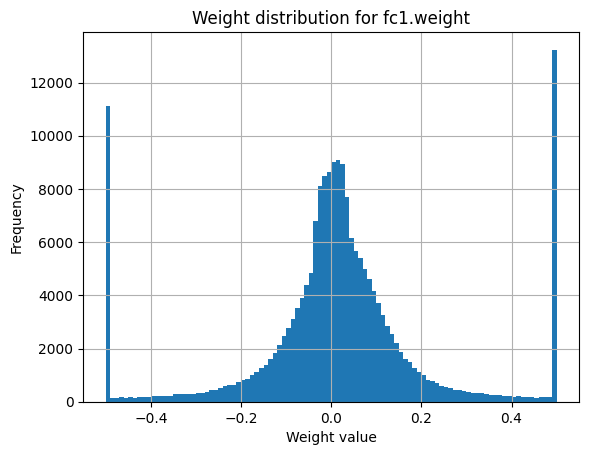

In [19]:
for name, param in model_flora.named_parameters():
    if param.requires_grad and name == 'fc1.weight':
        print(name, param.shape, param.device, param.dtype)
        data = param.data.cpu().numpy().flatten()
        data = np.clip(data, -0.5, 0.5)
        fig, ax = plt.subplots()
        ax.hist(data, bins=100)
        ax.set_title(f'Weight distribution for {name}')
        ax.set_xlabel('Weight value')
        ax.set_ylabel('Frequency')
        ax.grid()
        fig.show()

/tmp/ipykernel_2913501/1670698881.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


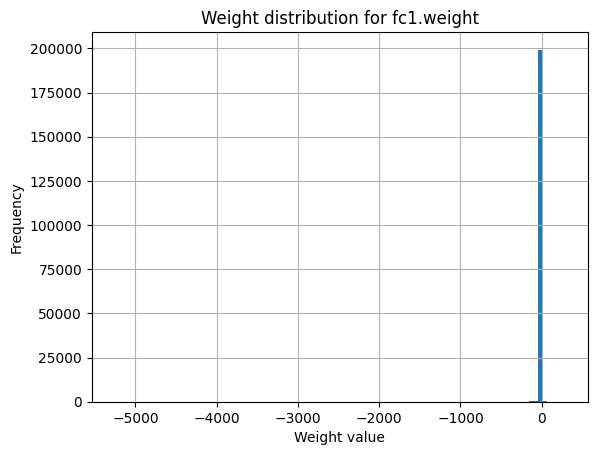

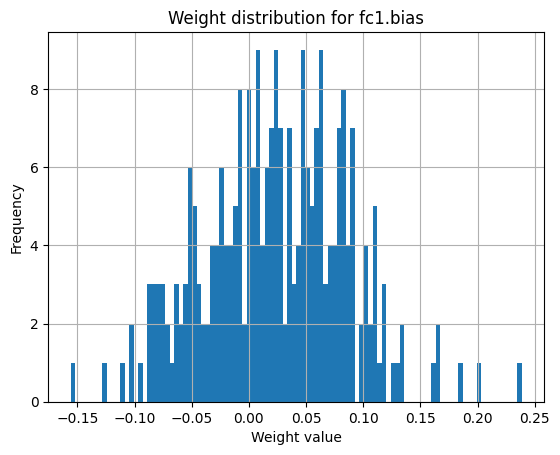

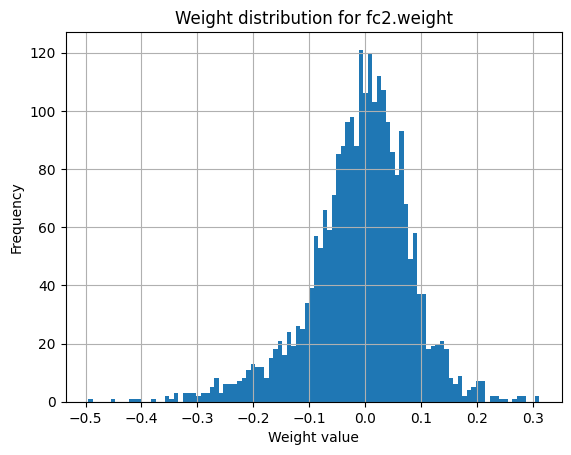

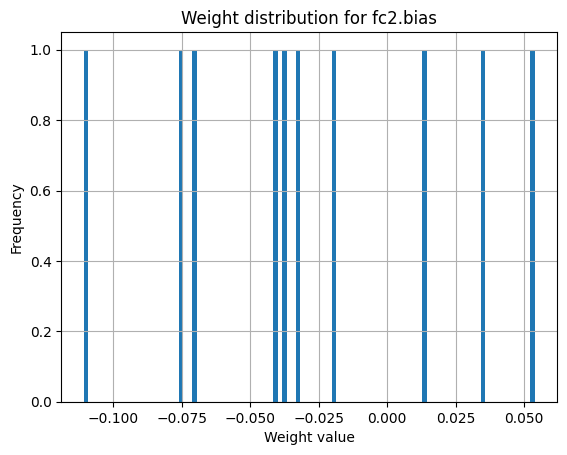

In [15]:
plot_weights(model_flora)

/tmp/ipykernel_2913501/1670698881.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


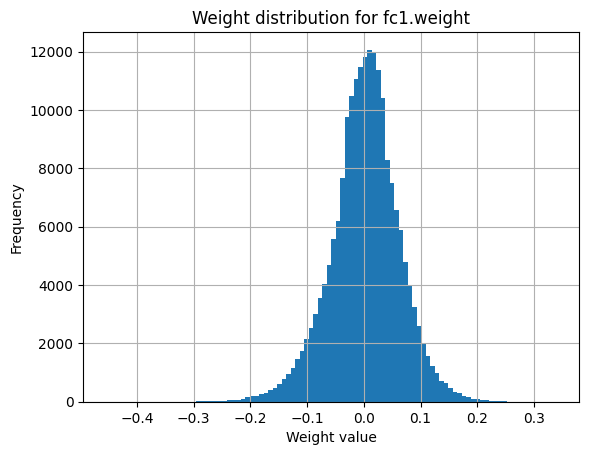

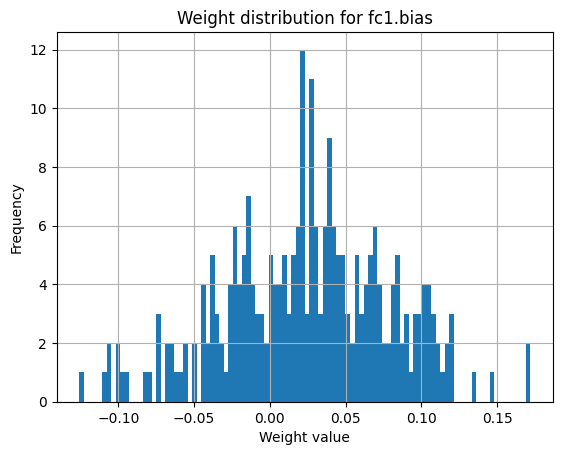

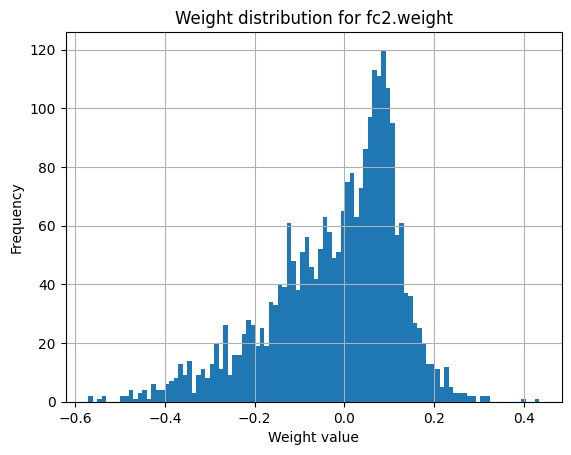

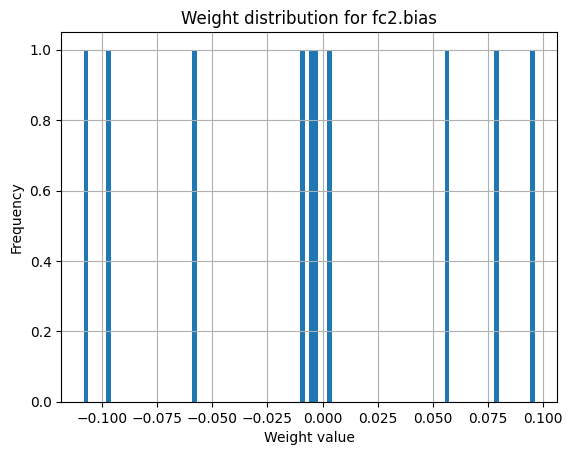

In [16]:
plot_weights(model_adam)